<b><i> ESM_processing&analysis </i></b>

- Purpose: Process ESM data 
- Methods: Analyse ocean bgc data (e.g., dissic), AMOC, and SAT in MPI-ESM simulations
- Comments: Works with DKRZ's Jupyterhub kernel python3/2023.1 on Levante
- Other resources:


# Load modules, variables, and functions

In [1]:
import xarray as xr
import numpy as np
import dask
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import os
import cdo # Import Cdo-py
cdo = cdo.Cdo(tempdir='/scratch/m/m300817/tmp/cdo-py') # change this to a directory in your scratch
import eccodes
import cfgrib
import zlib
from tqdm import tqdm

In [2]:
g_per_molC = 12.0107  # to convert units to g, as dissic units are given in mol m-3

In [3]:
def weighted_area_lat(ds):
    """
    Calculate the area-weighted temperature over its domain. 
    In a regular latitude/ longitude grid the grid cell area decreases towards the pole.
    We can use the cosine of the latitude as proxy for the grid cell area.
    Taken from https://docs.xarray.dev/en/stable/examples/area_weighted_temperature.html
    """
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"

    return ds.weighted(weights)

In [4]:
def weighted_mon_to_year_mean(ds, var):
    """
    weight by days in each month when doing annual mean from monthly values in xarray
    taken from https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    month_length = ds.time.dt.days_in_month # Determine the month length
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()  # Calculate the weights
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)  # Make sure the weights in each year add up to 1
    obs = ds[var]  # Subset our dataset for our variable
    cond = obs.isnull() # Setup our masking for nan values
    ones = xr.where(cond, 0.0, 1.0)   
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")  # Calculate the numerator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time") # Calculate the denominator
    return obs_sum / ones_out # Return the weighted average

# Load data (MPI-ESM1.2-LR)

## Dissolved inorganic Carbon (dissic)

### 1pctCO2

In [6]:
# Load DIC in 1pctCO2-bgc
file_type = 'dissic'
infiles = glob.glob(f'/pool/data/CMIP6/data/C4MIP/MPI-M/MPI-ESM1-2-LR/1pctCO2-bgc/r1i1p1f1/Omon/{file_type}/gn/v20190710/*{file_type}*.nc')
ds_dissic_1pctbgc = xr.open_mfdataset(infiles, use_cftime=True, parallel=True, chunks={"time": 10})

### New hosing 1pct & scenarios

1pctbgc

In [4]:
# Pre-process (select and merge) dissic yearly
wildcard = "*hamocc_data_3d_ym_*"
for exp in ["hosing_naa01Sv_1pctbgc-LR","hosing_naa03Sv_1pctbgc-LR", "hosing_naa05Sv_1pctbgc-LR",
            "hosing_grc01Sv_1pctbgc-LR", "hosing_grc03Sv_1pctbgc-LR", "hosing_grc05Sv_1pctbgc-LR",
            "hosing_naa03Sv_1pct-LR", "hosing_naa05Sv_1pct-LR"]:
    in_path  = f'/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/{exp}/outdata/hamocc/'
    ifiles   = in_path+wildcard
    outpath = "/work/uo1075/m300817/hosing/post/data/dissic/"
    outfile = f"{exp}_dissic.nc"
    if not glob.glob(outpath):
        os.mkdir(outpath)
    if not os.path.isfile(outpath+outfile):
        cdo.mergetime(input = "-select,name=dissic "+ifiles, output = outpath+outfile)

In [7]:
# Load resulting file. NOTE: HERE IS DIRECTLY YEARLY MEANS
ds_dissic_u011pctbgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_naa01Sv_1pctbgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_u031pctbgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_naa03Sv_1pctbgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_u051pctbgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_naa05Sv_1pctbgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_g011pctbgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_grc01Sv_1pctbgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_g031pctbgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_grc03Sv_1pctbgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_g051pctbgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_grc05Sv_1pctbgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_u031pctLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_naa03Sv_1pct-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_u051pctLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_naa05Sv_1pct-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})

hist-bgc and u03 bgc-scenarios

In [7]:
# Pre-process (select and merge) dissic yearly
wildcard = "*hamocc_data_3d_ym_*"
for exp in ["histbgc-LR","hosing_naa03Sv_ssp126bgc-LR", "hosing_naa03Sv_ssp245bgc-LR",
            "hosing_naa03Sv_ssp585bgc-LR"]:
    in_path  = f'/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/{exp}/outdata/hamocc/'
    ifiles   = in_path+wildcard
    outpath = "/work/uo1075/m300817/hosing/post/data/dissic/"
    outfile = f"{exp}_dissic.nc"
    if not glob.glob(outpath):
        os.mkdir(outpath)
    if not os.path.isfile(outpath+outfile):
        cdo.mergetime(input = "-select,name=dissic "+ifiles, output = outpath+outfile)

In [8]:
# Load resulting file. NOTE: HERE IS DIRECTLY YEARLY MEANS
ds_dissic_histbgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/histbgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_u03ssp126bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_naa03Sv_ssp126bgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_u03ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_naa03Sv_ssp245bgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_u03ssp585bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_naa03Sv_ssp585bgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})

ssp245bgc

In [ ]:
# Pre-process (select and merge) dissic yearly
wildcard = "*hamocc_data_3d_ym_*"
for exp in ["hosing_naa01Sv_ssp245bgc-LR","hosing_naa03Sv_ssp245bgc-LR", "hosing_naa05Sv_ssp245bgc-LR",
            "hosing_grc01Sv_ssp245bgc-LR", "hosing_grc03Sv_ssp245bgc-LR", "hosing_grc05Sv_ssp245bgc-LR",
            "ssp245bgc-LR"]:
    in_path  = f'/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/{exp}/outdata/hamocc/'
    ifiles   = in_path+wildcard
    outpath = "/work/uo1075/m300817/hosing/post/data/dissic/"
    outfile = f"{exp}_dissic.nc"
    if not glob.glob(outpath):
        os.mkdir(outpath)
    if not os.path.isfile(outpath+outfile):
        cdo.mergetime(input = "-select,name=dissic "+ifiles, output = outpath+outfile)

In [10]:
# Load resulting file. NOTE: HERE IS DIRECTLY YEARLY MEANS
ds_dissic_u01ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_naa01Sv_ssp245bgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_u03ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_naa03Sv_ssp245bgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_u05ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_naa05Sv_ssp245bgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_g01ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_grc01Sv_ssp245bgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_g03ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_grc03Sv_ssp245bgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_g05ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/hosing_grc05Sv_ssp245bgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})
ds_dissic_ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/dissic/ssp245bgc-LR_dissic.nc"
                                       , use_cftime=True, parallel=True, chunks={"time": 10})

## AMOC (msftmz)

### 1pctCO2

In [14]:
# Load amoc in 1pctCO2-bgc
file_type = 'msftmz'
infiles = glob.glob(f'/pool/data/CMIP6/data/C4MIP/MPI-M/MPI-ESM1-2-LR/1pctCO2-bgc/r1i1p1f1/Omon/{file_type}/gn/v20190710/*{file_type}*.nc')
ds_msftmz_1pctbgc = xr.open_mfdataset(infiles, use_cftime=True, parallel=True)

### New hosing 1pct & scenario

1pct-bgc

In [15]:
ds_msftmz_u011pctbgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_naa01Sv_1pctbgc-LR/outdata/mpiom/*moc_mm*",
                                       use_cftime=True)
ds_msftmz_u031pctbgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_naa03Sv_1pctbgc-LR/outdata/mpiom/*moc_mm*",
                                       use_cftime=True)
ds_msftmz_u031pctLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_naa03Sv_1pct-LR/outdata/mpiom/*moc_mm*",
                                       use_cftime=True)
ds_msftmz_u051pctbgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_naa05Sv_1pctbgc-LR/outdata/mpiom/*moc_mm*",
                                       use_cftime=True)
ds_msftmz_u051pctLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_naa05Sv_1pct-LR/outdata/mpiom/*moc_mm*",
                                       use_cftime=True)
ds_msftmz_g011pctbgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_grc01Sv_1pctbgc-LR/outdata/mpiom/*moc_mm*",
                                       use_cftime=True)
ds_msftmz_g031pctbgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_grc03Sv_1pctbgc-LR/outdata/mpiom/*moc_mm*",
                                       use_cftime=True)
ds_msftmz_g051pctbgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_grc05Sv_1pctbgc-LR/outdata/mpiom/*moc_mm*",
                                       use_cftime=True)

hist-bgc and u03 bgc-scenarios

In [16]:
ds_msftmz_histbgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/histbgc-LR/outdata/mpiom/*moc_mm*",
                                        use_cftime=True)
ds_msftmz_u03ssp126bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_naa03Sv_ssp126bgc-LR/outdata/mpiom/*moc_mm*",
                                             use_cftime=True)
ds_msftmz_u03ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_naa03Sv_ssp245bgc-LR/outdata/mpiom/*moc_mm*",
                                             use_cftime=True)
ds_msftmz_u03ssp585bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_naa03Sv_ssp585bgc-LR/outdata/mpiom/*moc_mm*", 
                                             use_cftime=True)

ssp245bgc

In [13]:
ds_msftmz_ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/ssp245bgc-LR/outdata/mpiom/*moc_mm*",
                                        use_cftime=True)
ds_msftmz_u05ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_naa05Sv_ssp245bgc-LR/outdata/mpiom/*moc_mm*",
                                             use_cftime=True)
ds_msftmz_u03ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_naa03Sv_ssp245bgc-LR/outdata/mpiom/*moc_mm*",
                                             use_cftime=True)
ds_msftmz_u01ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_naa01Sv_ssp245bgc-LR/outdata/mpiom/*moc_mm*",
                                             use_cftime=True)
ds_msftmz_g05ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_grc05Sv_ssp245bgc-LR/outdata/mpiom/*moc_mm*",
                                             use_cftime=True)
ds_msftmz_g03ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_grc03Sv_ssp245bgc-LR/outdata/mpiom/*moc_mm*",
                                             use_cftime=True)
ds_msftmz_g01ssp245bgcLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/mpiesm-1.2.01p7-passivesalt-hosing/experiments/hosing_grc01Sv_ssp245bgc-LR/outdata/mpiom/*moc_mm*",
                                             use_cftime=True)

## volcello 

### cmorised output

In [15]:
infiles = glob.glob('/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Ofx/volcello/gn/v20190710/*.nc')
ds_volcello = xr.open_mfdataset(infiles, use_cftime=True, parallel=True)

### mpi-esm direct output

In [ ]:
# Pre-process volcello mpi output
in_path  = '/work/mh0033/from_Mistral/mh0033/m300817/mpiesm-1.2.01p6-passivesalt_update/experiments/hosing_naa05Sv_FcSV-LR/outdata/mpiom/'
filefx = "hosing_naa05Sv_FcSV-LR_mpiom_fx_18500101_18501231.nc
ifiles   = in_path+filefx
outpath = "/work/uo0122/m300817/hosing/post/data/fx/"
outfile = "hosing_naa05Sv_FcSV-LR_volcello.nc"
if not glob.glob(outpath):
    os.mkdir(outpath)
if not os.path.isfile(outpath+outfile):
    #cdo(input = "expr,’volcello=areacello*thkcello’ "+ifiles, output = outpath+outfile)
    cdo(input = " -expr,'volcello=areacello*thkcello' "+ifiles, output = outpath+outfile)

In [14]:
# Load resulting file, same for both hosing configurations (note: now in new location)
ds_volcello_u05hosLR = xr.open_mfdataset("/work/uo1075/m300817/hosing/post/data/fx/hosing_naa05Sv_FcSV-LR_volcello.nc"
                                       , use_cftime=True, parallel=True)

In [15]:
ds_volcello_u05hosLR = ds_volcello_u05hosLR.rename({'x_2':'x', 'y_2':'y', 'lat_2': 'lat','lon_2': 'lon', 'depth_2': 'depth'})

In [40]:
# Total DIC full depth (0-5720m) u03hosLR last vs first 10 years
u03_total_full = ((ds_dissic_u03hosLR.dissic.isel(time=np.arange(-120,-0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
-(ds_dissic_u03hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
).sum(dim='y').sum(dim='x').values

In [41]:
# Total DIC below 1000m (1085-5720m) u03hosLR last vs first 10 years
u03_total_deep =  ((ds_dissic_u03hosLR.dissic.isel(time=np.arange(-120,-0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
-(ds_dissic_u03hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
).sum(dim='y').sum(dim='x').values

In [42]:
# Total DIC above 1000m (0-1085m) u03hosLR last vs first 10 years
u03_total_surf = ((ds_dissic_u03hosLR.dissic.isel(time=np.arange(-120,-0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
-(ds_dissic_u03hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
).sum(dim='y').sum(dim='x').values

Text(-0.08, 1, '40.531 PgC')

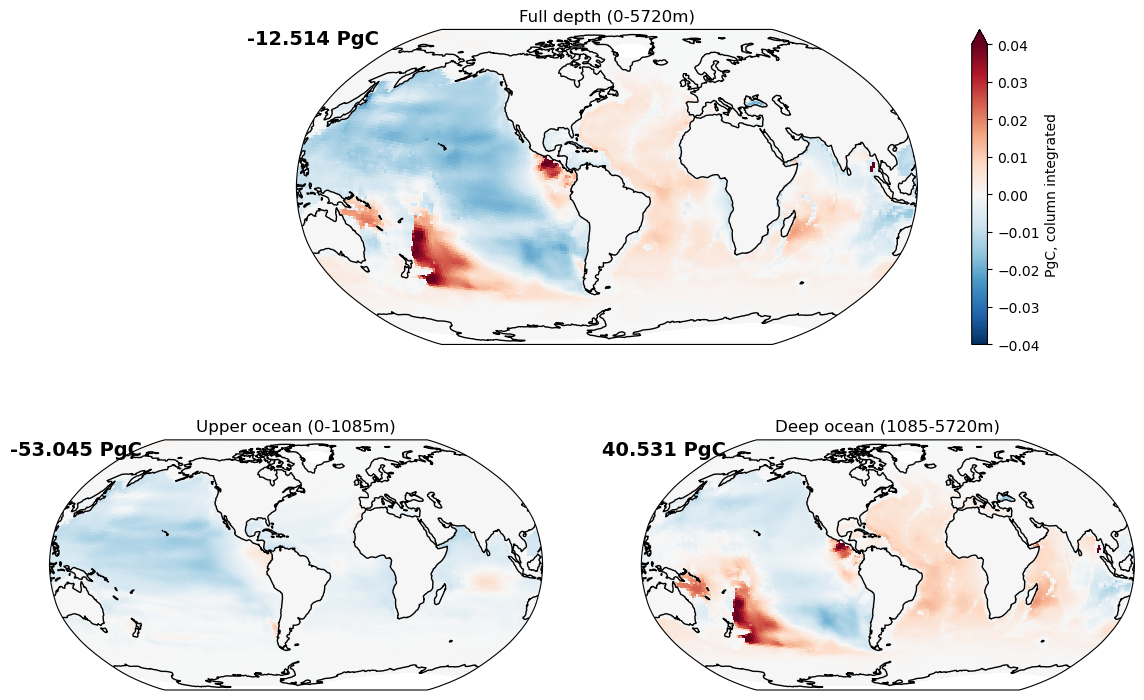

In [43]:
fig=plt.figure(figsize=(14, 9))

ax1 = fig.add_subplot(211, projection=ccrs.Robinson(central_longitude=-60))
ax1.set_global()
((ds_dissic_u03hosLR.dissic.isel(time=np.arange(-120,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
-(ds_dissic_u03hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
).plot.pcolormesh(
    ax=ax1, transform=ccrs.PlateCarree(), x="lon", y="lat", vmin=-0.040, vmax=0.040, cmap='RdBu_r', cbar_kwargs={'label': 'PgC, column integrated'})
ax1.coastlines()
ax1.set_title("Full depth (0-5720m)") 
ax1.text(-0.08, 1, str(round(u03_total_full.item(), 3))+" PgC", transform=ax1.transAxes, fontsize=14,
        verticalalignment='top' , fontweight='bold')

ax2 = fig.add_subplot(223, projection=ccrs.Robinson(central_longitude=-60))
ax2.set_global()
((ds_dissic_u03hosLR.dissic.isel(time=np.arange(-120,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
-(ds_dissic_u03hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
).plot.pcolormesh(
    ax=ax2, transform=ccrs.PlateCarree(), x="lon", y="lat", cmap='RdBu_r', vmin=-0.040, vmax=0.040, add_colorbar=False)
ax2.coastlines()
ax2.set_title("Upper ocean (0-1085m)") 
ax2.text(-0.08, 1, str(round(u03_total_surf.item(), 3))+" PgC", transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', fontweight='bold')

ax3 = fig.add_subplot(224, projection=ccrs.Robinson(central_longitude=-60))
ax3.set_global()
((ds_dissic_u03hosLR.dissic.isel(time=np.arange(-120,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
-(ds_dissic_u03hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
).plot.pcolormesh(
   ax=ax3, transform=ccrs.PlateCarree(), x="lon", y="lat", cmap='RdBu_r', vmin=-0.040, vmax=0.040, add_colorbar=False)
ax3.coastlines()
ax3.set_title("Deep ocean (1085-5720m)") 

ax3.text(-0.08, 1, str(round(u03_total_deep.item(), 3))+" PgC", transform=ax3.transAxes, fontsize=14,
        verticalalignment='top', fontweight='bold')

In [44]:
ds_dissic_u05hosLR.load()

<xarray.Dataset>
Dimensions:   (time: 2400, y: 220, x: 256, vertices: 4, depth: 40)
Coordinates:
  * time      (time) object 1850-01-31 23:15:00 ... 2049-12-31 23:15:00
    lon       (y, x) float64 -47.25 -47.69 -48.12 -48.54 ... 131.3 132.5 133.8
    lat       (y, x) float64 76.36 76.3 76.24 76.17 ... -77.25 -77.39 -77.54
  * depth     (depth) float64 6.0 17.0 27.0 37.0 ... 4.67e+03 5.17e+03 5.72e+03
Dimensions without coordinates: y, x, vertices
Data variables:
    lon_bnds  (y, x, vertices) float64 -46.47 -46.69 -47.15 ... 133.2 133.5
    lat_bnds  (y, x, vertices) float64 76.38 76.49 76.44 ... -77.47 -77.33
    dissic    (time, depth, y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.4
    MPIOM:        $Revision: 36c4129465cbb139f26d9780e9601a157eaa3a93 $
    history:      Thu Oct 05 15:23:54 2023: cdo -O -s -mergetime -select,name...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [45]:
# Total DIC full depth (0-5720m) u05hosLR last vs first 10 years
u05_total_full = ((ds_dissic_u05hosLR.dissic.isel(time=np.arange(-120,-0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
-(ds_dissic_u05hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
).sum(dim='y').sum(dim='x').values

In [46]:
# Total DIC below 1000m (1085-5720m) u05hosLR last vs first 10 years
u05_total_deep = ((ds_dissic_u05hosLR.dissic.isel(time=np.arange(-120,-0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
-(ds_dissic_u05hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
).sum(dim='y').sum(dim='x').values

In [47]:
# Total DIC above 1000m (0-1085m) u05hosLR last vs first 10 years
u05_total_surf = ((ds_dissic_u05hosLR.dissic.isel(time=np.arange(-120,-0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
-(ds_dissic_u05hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
).sum(dim='y').sum(dim='x').values

Text(-0.08, 1.1, '50.372 PgC')

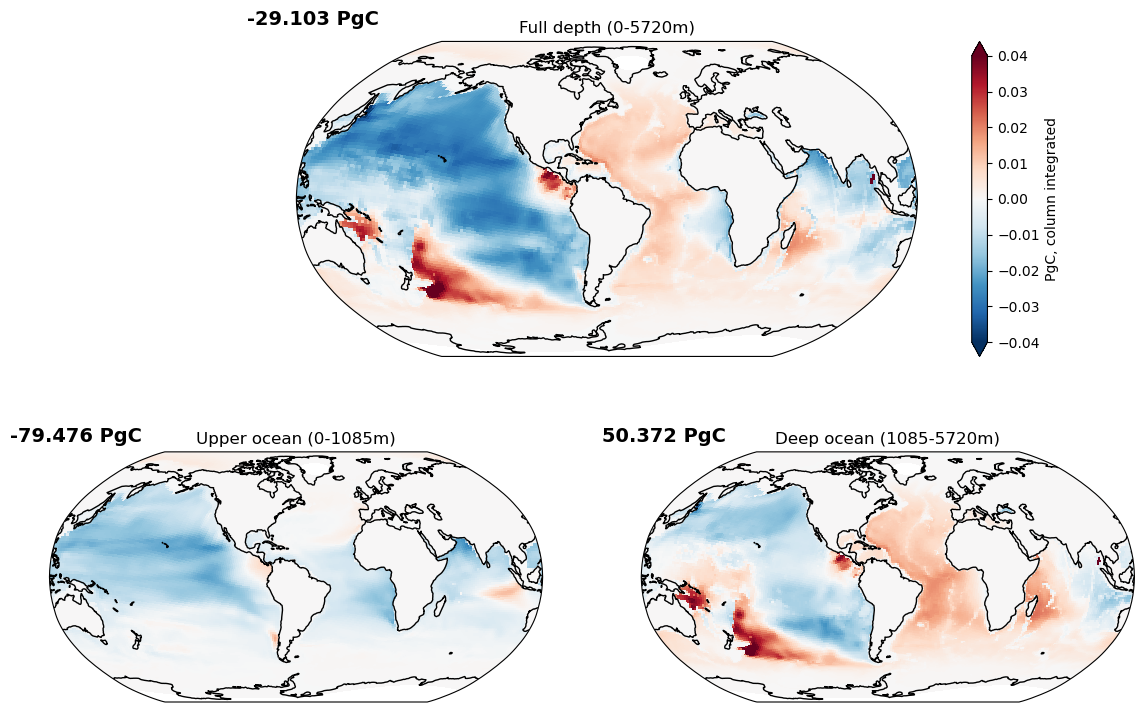

In [48]:
fig=plt.figure(figsize=(14, 9))

ax1 = fig.add_subplot(211, projection=ccrs.Robinson(central_longitude=-60))
ax1.set_global()
((ds_dissic_u05hosLR.dissic.isel(time=np.arange(-120,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
-(ds_dissic_u05hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
).plot.pcolormesh(
    ax=ax1, transform=ccrs.PlateCarree(), x="lon", y="lat", vmin=-0.040, vmax=0.040, cmap='RdBu_r', cbar_kwargs={'label': 'PgC, column integrated'})
ax1.coastlines()
ax1.set_title("Full depth (0-5720m)") 
ax1.text(-0.08, 1.1, str(round(u05_total_full.item(), 3))+" PgC", transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', fontweight='bold')

ax2 = fig.add_subplot(223, projection=ccrs.Robinson(central_longitude=-60))
ax2.set_global()
((ds_dissic_u05hosLR.dissic.isel(time=np.arange(-120,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
-(ds_dissic_u05hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
).plot.pcolormesh(
    ax=ax2, transform=ccrs.PlateCarree(), x="lon", y="lat", cmap='RdBu_r', vmin=-0.040, vmax=0.040, add_colorbar=False)
ax2.coastlines()
ax2.set_title("Upper ocean (0-1085m)") 
ax2.text(-0.08, 1.1, str(round(u05_total_surf.item(), 3))+" PgC", transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', fontweight='bold')

ax3 = fig.add_subplot(224, projection=ccrs.Robinson(central_longitude=-60))
ax3.set_global()
((ds_dissic_u05hosLR.dissic.isel(time=np.arange(-120,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
-(ds_dissic_u05hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
).plot.pcolormesh(
   ax=ax3, transform=ccrs.PlateCarree(), x="lon", y="lat", cmap='RdBu_r', vmin=-0.040, vmax=0.040, add_colorbar=False)
ax3.coastlines()
ax3.set_title("Deep ocean (1085-5720m)") 
ax3.text(-0.08, 1.1, str(round(u05_total_deep.item(), 3))+" PgC", transform=ax3.transAxes, fontsize=14,
        verticalalignment='top', fontweight='bold')

In [49]:
ds_dissic_g03hosLR.load()

<xarray.Dataset>
Dimensions:   (time: 2400, y: 220, x: 256, vertices: 4, depth: 40)
Coordinates:
  * time      (time) object 1850-01-31 23:15:00 ... 2049-12-31 23:15:00
    lon       (y, x) float64 -47.25 -47.69 -48.12 -48.54 ... 131.3 132.5 133.8
    lat       (y, x) float64 76.36 76.3 76.24 76.17 ... -77.25 -77.39 -77.54
  * depth     (depth) float64 6.0 17.0 27.0 37.0 ... 4.67e+03 5.17e+03 5.72e+03
Dimensions without coordinates: y, x, vertices
Data variables:
    lon_bnds  (y, x, vertices) float64 -46.47 -46.69 -47.15 ... 133.2 133.5
    lat_bnds  (y, x, vertices) float64 76.38 76.49 76.44 ... -77.47 -77.33
    dissic    (time, depth, y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.4
    MPIOM:        $Revision: 36c4129465cbb139f26d9780e9601a157eaa3a93 $
    history:      Wed Nov 15 15:00:06 2023: cdo -O -s -mergetime -select,name...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [50]:
# Total DIC full depth (0-5720m) u05hosLR last vs first 10 years
g03_total_full = ((ds_dissic_g03hosLR.dissic.isel(time=np.arange(-120,-0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
-(ds_dissic_g03hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
).sum(dim='y').sum(dim='x').values

In [51]:
# Total DIC below 1000m (1085-5720m) u05hosLR last vs first 10 years
g03_total_deep = ((ds_dissic_g03hosLR.dissic.isel(time=np.arange(-120,-0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
-(ds_dissic_g03hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
).sum(dim='y').sum(dim='x').values

In [52]:
# Total DIC above 1000m (0-1085m) u05hosLR last vs first 10 years
g03_total_surf = ((ds_dissic_g03hosLR.dissic.isel(time=np.arange(-120,-0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
-(ds_dissic_g03hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
).sum(dim='y').sum(dim='x').values

Text(-0.08, 1, '19.272 PgC')

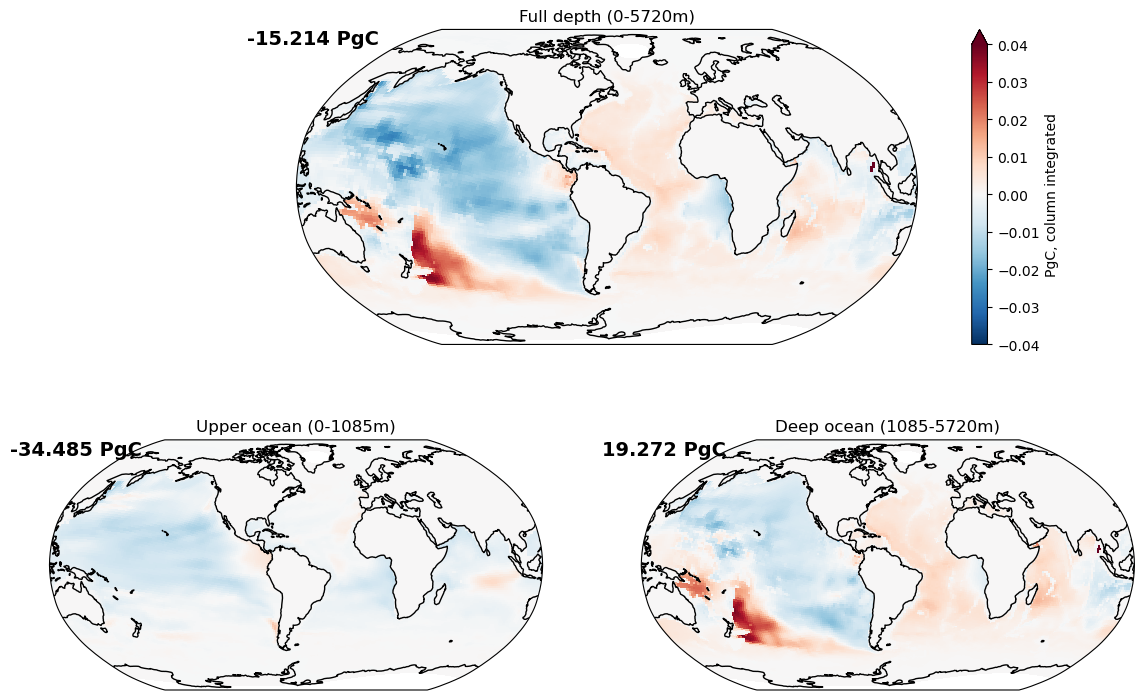

In [53]:
fig=plt.figure(figsize=(14, 9))

ax1 = fig.add_subplot(211, projection=ccrs.Robinson(central_longitude=-60))
ax1.set_global()
((ds_dissic_g03hosLR.dissic.isel(time=np.arange(-120,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
-(ds_dissic_g03hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
).plot.pcolormesh(
    ax=ax1, transform=ccrs.PlateCarree(), x="lon", y="lat", vmin=-0.040, vmax=0.040, cmap='RdBu_r', cbar_kwargs={'label': 'PgC, column integrated'})
ax1.coastlines()
ax1.set_title("Full depth (0-5720m)") 
ax1.text(-0.08, 1, str(round(g03_total_full.item(), 3))+" PgC", transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', fontweight='bold')

ax2 = fig.add_subplot(223, projection=ccrs.Robinson(central_longitude=-60))
ax2.set_global()
((ds_dissic_g03hosLR.dissic.isel(time=np.arange(-120,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
-(ds_dissic_g03hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
).plot.pcolormesh(
    ax=ax2, transform=ccrs.PlateCarree(), x="lon", y="lat", cmap='RdBu_r', vmin=-0.040, vmax=0.040, add_colorbar=False)
ax2.coastlines()
ax2.set_title("Upper ocean (0-1085m)") 
ax2.text(-0.08, 1, str(round(g03_total_surf.item(), 3))+" PgC", transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', fontweight='bold')


ax3 = fig.add_subplot(224, projection=ccrs.Robinson(central_longitude=-60))
ax3.set_global()
((ds_dissic_g03hosLR.dissic.isel(time=np.arange(-120,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
-(ds_dissic_g03hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
).plot.pcolormesh(
   ax=ax3, transform=ccrs.PlateCarree(), x="lon", y="lat", cmap='RdBu_r', vmin=-0.040, vmax=0.040, add_colorbar=False)
ax3.coastlines()
ax3.set_title("Deep ocean (1085-5720m)")
ax3.text(-0.08, 1, str(round(g03_total_deep.item(), 3))+" PgC", transform=ax3.transAxes, fontsize=14,
        verticalalignment='top', fontweight='bold')

In [54]:
ds_dissic_g01hosLR.load()

<xarray.Dataset>
Dimensions:   (time: 200, y: 220, x: 256, vertices: 4, depth: 40)
Coordinates:
  * time      (time) object 1850-12-31 23:15:00 ... 2049-12-31 23:15:00
    lon       (y, x) float64 -47.25 -47.69 -48.12 -48.54 ... 131.3 132.5 133.8
    lat       (y, x) float64 76.36 76.3 76.24 76.17 ... -77.25 -77.39 -77.54
  * depth     (depth) float64 6.0 17.0 27.0 37.0 ... 4.67e+03 5.17e+03 5.72e+03
Dimensions without coordinates: y, x, vertices
Data variables:
    lon_bnds  (y, x, vertices) float64 -46.47 -46.69 -47.15 ... 133.2 133.5
    lat_bnds  (y, x, vertices) float64 76.38 76.49 76.44 ... -77.47 -77.33
    dissic    (time, depth, y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.4
    MPIOM:        $Revision: 36c4129465cbb139f26d9780e9601a157eaa3a93 $
    history:      Wed Nov 15 15:29:04 2023: cdo -O -s -mergetime -select,name...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [55]:
# Total DIC full depth (0-5720m) u05hosLR last vs first 10 years
g01_total_full = ((ds_dissic_g01hosLR.dissic.isel(time=np.arange(-10,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
-(ds_dissic_g01hosLR.dissic.isel(time=np.arange(0,10)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
).sum(dim='y').sum(dim='x').values

In [56]:
# Total DIC below 1000m (1085-5720m) u05hosLR last vs first 10 years
g01_total_deep = ((ds_dissic_g01hosLR.dissic.isel(time=np.arange(-10,-0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
-(ds_dissic_g01hosLR.dissic.isel(time=np.arange(0,10)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
).sum(dim='y').sum(dim='x').values

In [57]:
# Total DIC above 1000m (0-1085m) u05hosLR last vs first 10 years
g01_total_surf = ((ds_dissic_g01hosLR.dissic.isel(time=np.arange(-10,-0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
-(ds_dissic_g01hosLR.dissic.isel(time=np.arange(0,10)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
).sum(dim='y').sum(dim='x').values

Text(-0.08, 1, '12.674 PgC')

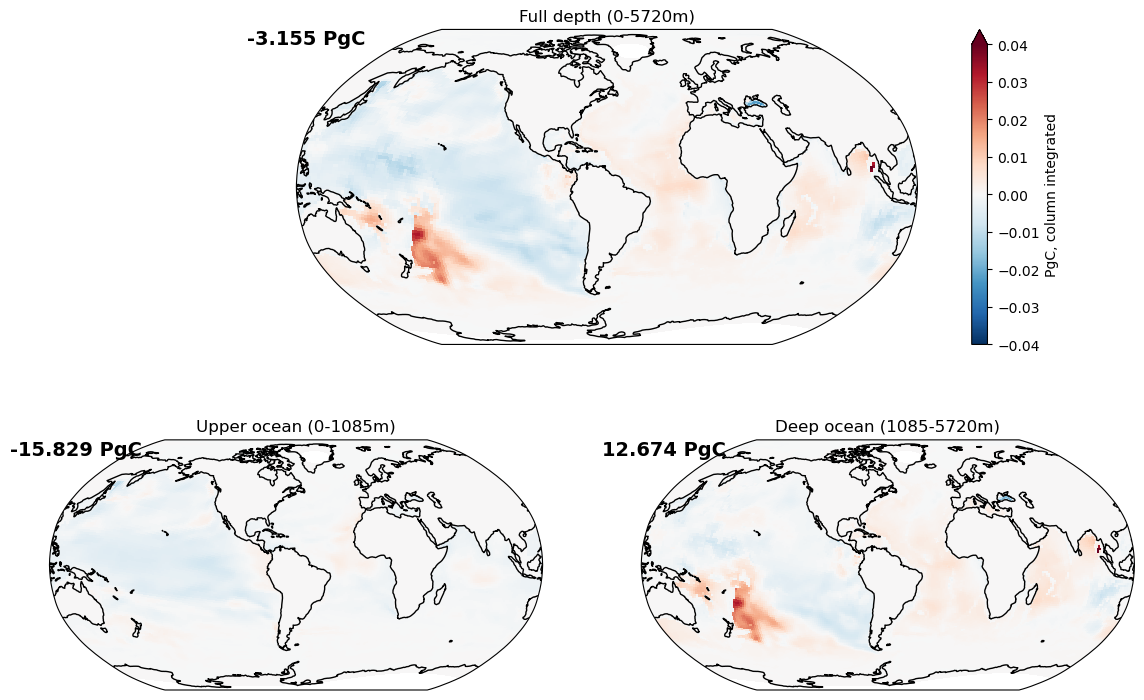

In [58]:
fig=plt.figure(figsize=(14, 9))

ax1 = fig.add_subplot(211, projection=ccrs.Robinson(central_longitude=-60))
ax1.set_global()
((ds_dissic_g01hosLR.dissic.isel(time=np.arange(-10,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
-(ds_dissic_g01hosLR.dissic.isel(time=np.arange(0,10)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
).plot.pcolormesh(
    ax=ax1, transform=ccrs.PlateCarree(), x="lon", y="lat", vmin=-0.040, vmax=0.040, cmap='RdBu_r', cbar_kwargs={'label': 'PgC, column integrated'})
ax1.coastlines()
ax1.set_title("Full depth (0-5720m)") 
ax1.text(-0.08, 1, str(round(g01_total_full.item(), 3))+" PgC", transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', fontweight='bold')

ax2 = fig.add_subplot(223, projection=ccrs.Robinson(central_longitude=-60))
ax2.set_global()
((ds_dissic_g01hosLR.dissic.isel(time=np.arange(-10,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
-(ds_dissic_g01hosLR.dissic.isel(time=np.arange(0,10)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,23)).sum(dim='depth')
).plot.pcolormesh(
    ax=ax2, transform=ccrs.PlateCarree(), x="lon", y="lat", cmap='RdBu_r', vmin=-0.040, vmax=0.040, add_colorbar=False)
ax2.coastlines()
ax2.set_title("Upper ocean (0-1085m)") 
ax2.text(-0.08, 1, str(round(g01_total_surf.item(), 3))+" PgC", transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', fontweight='bold')

ax3 = fig.add_subplot(224, projection=ccrs.Robinson(central_longitude=-60))
ax3.set_global()
((ds_dissic_g01hosLR.dissic.isel(time=np.arange(-10,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
-(ds_dissic_g01hosLR.dissic.isel(time=np.arange(0,10)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(23,40)).sum(dim='depth')
).plot.pcolormesh(
   ax=ax3, transform=ccrs.PlateCarree(), x="lon", y="lat", cmap='RdBu_r', vmin=-0.040, vmax=0.040, add_colorbar=False)
ax3.coastlines()
ax3.set_title("Deep ocean (1085-5720m)")
ax3.text(-0.08, 1, str(round(g01_total_deep.item(), 3))+" PgC", transform=ax3.transAxes, fontsize=14,
        verticalalignment='top', fontweight='bold')

Text(-0.1, 1.1, '-3.155 PgC')

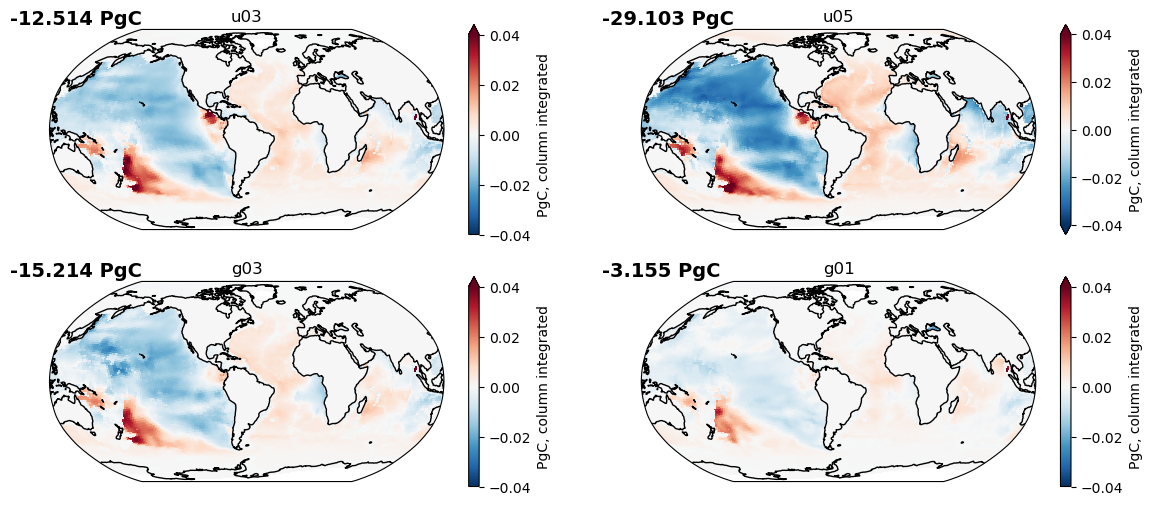

In [59]:
fig=plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(221, projection=ccrs.Robinson(central_longitude=-60))
ax1.set_global()
((ds_dissic_u03hosLR.dissic.isel(time=np.arange(-120,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
-(ds_dissic_u03hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
).plot.pcolormesh(
    ax=ax1, transform=ccrs.PlateCarree(), x="lon", y="lat", vmin=-0.040, vmax=0.040, cmap='RdBu_r', cbar_kwargs={'label': 'PgC, column integrated'})
ax1.coastlines()
ax1.set_title("u03")
ax1.text(-0.1, 1.1, str(round(u03_total_full.item(), 3))+" PgC", transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', fontweight='bold')

ax2 = fig.add_subplot(222, projection=ccrs.Robinson(central_longitude=-60))
ax2.set_global()
((ds_dissic_u05hosLR.dissic.isel(time=np.arange(-120,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
-(ds_dissic_u05hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
).plot.pcolormesh(
    ax=ax2, transform=ccrs.PlateCarree(), x="lon", y="lat", vmin=-0.040, vmax=0.040, cmap='RdBu_r', cbar_kwargs={'label': 'PgC, column integrated'})
ax2.coastlines()
ax2.set_title("u05")
ax2.text(-0.1, 1.1, str(round(u05_total_full.item(), 3))+" PgC", transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', fontweight='bold')


ax3 = fig.add_subplot(223, projection=ccrs.Robinson(central_longitude=-60))
ax3.set_global()
((ds_dissic_g03hosLR.dissic.isel(time=np.arange(-120,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
-(ds_dissic_g03hosLR.dissic.isel(time=np.arange(0,120)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
).plot.pcolormesh(
    ax=ax3, transform=ccrs.PlateCarree(), x="lon", y="lat", vmin=-0.040, vmax=0.040, cmap='RdBu_r', cbar_kwargs={'label': 'PgC, column integrated'})
ax3.coastlines()
ax3.set_title("g03")
ax3.text(-0.1, 1.1, str(round(g03_total_full.item(), 3))+" PgC", transform=ax3.transAxes, fontsize=14,
        verticalalignment='top', fontweight='bold')


ax4 = fig.add_subplot(224, projection=ccrs.Robinson(central_longitude=-60))
ax4.set_global()
((ds_dissic_g01hosLR.dissic.isel(time=np.arange(-10,0)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
-(ds_dissic_g01hosLR.dissic.isel(time=np.arange(0,10)).mean(dim="time")*ds_volcello_u05hosLR.mean(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
).plot.pcolormesh(
    ax=ax4, transform=ccrs.PlateCarree(), x="lon", y="lat", vmin=-0.040, vmax=0.040, cmap='RdBu_r', cbar_kwargs={'label': 'PgC, column integrated'})
ax4.coastlines()
ax4.set_title("g01")
ax4.text(-0.1, 1.1, str(round(g01_total_full.item(), 3))+" PgC", transform=ax4.transAxes, fontsize=14,
        verticalalignment='top', fontweight='bold')

In [23]:
ds_dissic_1pctbgc_year = ds_dissic_1pctbgc.dissic.groupby('time.year').mean('time')

In [25]:
ds_dissic_1pctbgc_year.load()
ds_dissic_u051pctbgcLR.load()
ds_dissic_u031pctbgcLR.load()
ds_dissic_u011pctbgcLR.load()
ds_dissic_g011pctbgcLR.load()
ds_dissic_g031pctbgcLR.load()
ds_dissic_g051pctbgcLR.load()

<xarray.Dataset>
Dimensions:   (time: 140, y: 220, x: 256, vertices: 4, depth: 40)
Coordinates:
  * time      (time) object 1850-12-31 23:15:00 ... 1989-12-31 23:15:00
    lon       (y, x) float64 -47.25 -47.69 -48.12 -48.54 ... 131.3 132.5 133.8
    lat       (y, x) float64 76.36 76.3 76.24 76.17 ... -77.25 -77.39 -77.54
  * depth     (depth) float64 6.0 17.0 27.0 37.0 ... 4.67e+03 5.17e+03 5.72e+03
Dimensions without coordinates: y, x, vertices
Data variables:
    lon_bnds  (y, x, vertices) float64 -46.47 -46.69 -47.15 ... 133.2 133.5
    lat_bnds  (y, x, vertices) float64 76.38 76.49 76.44 ... -77.47 -77.33
    dissic    (time, depth, y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.4
    MPIOM:        $Revision: 8637eee7f023c05182230a042556b592d81c679c $
    history:      Fri Apr 05 08:59:49 2024: cdo -O -s -mergetime -select,name...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [26]:
diff_dissic_u051pctbgc = []
diff_dissic_u031pctbgc = []
diff_dissic_u011pctbgc = []
diff_dissic_g011pctbgc = []
diff_dissic_g031pctbgc = []
diff_dissic_g051pctbgc = []
diff_dissic_1pctbgc    = []
for year in tqdm(range(1,140)):
    diff_dissic_u051pctbgc.append(
        ((ds_dissic_u051pctbgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_u051pctbgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)
    diff_dissic_u031pctbgc.append(
        ((ds_dissic_u031pctbgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_u031pctbgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)
    diff_dissic_u011pctbgc.append(
        ((ds_dissic_u011pctbgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_u011pctbgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)
    diff_dissic_g011pctbgc.append(
        ((ds_dissic_g011pctbgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_g011pctbgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)
    diff_dissic_g031pctbgc.append(
        ((ds_dissic_g031pctbgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_g031pctbgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)
    diff_dissic_g051pctbgc.append(
        ((ds_dissic_g051pctbgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_g051pctbgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)
    diff_dissic_1pctbgc.append(
        ((ds_dissic_1pctbgc_year.isel(year=np.arange(year,year+1))*ds_volcello.volcello*g_per_molC/1e15).isel(lev=np.arange(0,40)).sum(dim='lev')
        -(ds_dissic_1pctbgc_year.isel(year=0)*ds_volcello.volcello*g_per_molC/1e15).isel(lev=np.arange(0,40)).sum(dim='lev')
        ).sum(dim='j').sum(dim='i').values)

100%|██████████| 139/139 [01:31<00:00,  1.51it/s]


In [28]:
ds_dissic_u03ssp126bgcLR.load()
ds_dissic_u03ssp245bgcLR.load()
ds_dissic_u03ssp585bgcLR.load()

<xarray.Dataset>
Dimensions:   (time: 85, y: 220, x: 256, vertices: 4, depth: 40)
Coordinates:
  * time      (time) object 2015-12-31 23:15:00 ... 2099-12-31 23:15:00
    lon       (y, x) float64 -47.25 -47.69 -48.12 -48.54 ... 131.3 132.5 133.8
    lat       (y, x) float64 76.36 76.3 76.24 76.17 ... -77.25 -77.39 -77.54
  * depth     (depth) float64 6.0 17.0 27.0 37.0 ... 4.67e+03 5.17e+03 5.72e+03
Dimensions without coordinates: y, x, vertices
Data variables:
    lon_bnds  (y, x, vertices) float64 -46.47 -46.69 -47.15 ... 133.2 133.5
    lat_bnds  (y, x, vertices) float64 76.38 76.49 76.44 ... -77.47 -77.33
    dissic    (time, depth, y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.4
    MPIOM:        $Revision: 8637eee7f023c05182230a042556b592d81c679c $
    history:      Mon Aug 05 11:52:39 2024: cdo -O -s -mergetime -select,name...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [31]:
diff_dissic_ = []
diff_dissic_u03ssp126bgc = []
diff_dissic_u03ssp245bgc = []
diff_dissic_u03ssp585bgc = []

for year in tqdm(range(1,85)):
    diff_dissic_u03ssp126bgc.append(
        ((ds_dissic_u03ssp126bgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_u03ssp126bgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)
    diff_dissic_u03ssp245bgc.append(
        ((ds_dissic_u03ssp245bgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_u03ssp245bgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)
    diff_dissic_u03ssp585bgc.append(
        ((ds_dissic_u03ssp585bgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_u03ssp585bgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)

100%|██████████| 84/84 [00:24<00:00,  3.38it/s]


In [17]:
ds_dissic_u05ssp245bgcLR.load()
ds_dissic_u03ssp245bgcLR.load()
ds_dissic_u01ssp245bgcLR.load()
ds_dissic_g01ssp245bgcLR.load()
ds_dissic_g03ssp245bgcLR.load()
ds_dissic_g05ssp245bgcLR.load()
ds_dissic_ssp245bgcLR.load()

<xarray.Dataset>
Dimensions:   (time: 85, y: 220, x: 256, vertices: 4, depth: 40)
Coordinates:
  * time      (time) object 2015-12-31 23:15:00 ... 2099-12-31 23:15:00
    lon       (y, x) float64 -47.25 -47.69 -48.12 -48.54 ... 131.3 132.5 133.8
    lat       (y, x) float64 76.36 76.3 76.24 76.17 ... -77.25 -77.39 -77.54
  * depth     (depth) float64 6.0 17.0 27.0 37.0 ... 4.67e+03 5.17e+03 5.72e+03
Dimensions without coordinates: y, x, vertices
Data variables:
    lon_bnds  (y, x, vertices) float64 -46.47 -46.69 -47.15 ... 133.2 133.5
    lat_bnds  (y, x, vertices) float64 76.38 76.49 76.44 ... -77.47 -77.33
    dissic    (time, depth, y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.4
    MPIOM:        $Revision: 8637eee7f023c05182230a042556b592d81c679c $
    history:      Tue Aug 20 16:13:51 2024: cdo -O -s -mergetime -select,name...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [18]:
diff_dissic_u05ssp245bgc = []
diff_dissic_u03ssp245bgc = []
diff_dissic_u01ssp245bgc = []
diff_dissic_g01ssp245bgc = []
diff_dissic_g03ssp245bgc = []
diff_dissic_g05ssp245bgc = []
diff_dissic_ssp245bgc    = []
for year in tqdm(range(1,85)):
    diff_dissic_u05ssp245bgc.append(
        ((ds_dissic_u05ssp245bgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_u05ssp245bgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)
    diff_dissic_u03ssp245bgc.append(
        ((ds_dissic_u03ssp245bgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_u03ssp245bgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)
    diff_dissic_u01ssp245bgc.append(
        ((ds_dissic_u01ssp245bgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_u01ssp245bgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)
    diff_dissic_g01ssp245bgc.append(
        ((ds_dissic_g01ssp245bgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_g01ssp245bgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)
    diff_dissic_g03ssp245bgc.append(
        ((ds_dissic_g03ssp245bgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_g03ssp245bgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)
    diff_dissic_g05ssp245bgc.append(
        ((ds_dissic_g05ssp245bgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_g05ssp245bgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)
    diff_dissic_ssp245bgc.append(
        ((ds_dissic_ssp245bgcLR.dissic.isel(time=np.arange(year,year+1))*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        -(ds_dissic_ssp245bgcLR.dissic.isel(time=0)*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth')
        ).sum(dim='y').sum(dim='x').values)

100%|██████████| 84/84 [00:49<00:00,  1.68it/s]


In [28]:
diff_dissic_1pctbgc = np.array(diff_dissic_1pctbgc)
diff_dissic_g011pctbgc = np.array(diff_dissic_g011pctbgc)
diff_dissic_g031pctbgc = np.array(diff_dissic_g031pctbgc)
diff_dissic_g051pctbgc = np.array(diff_dissic_g051pctbgc)
diff_dissic_u011pctbgc = np.array(diff_dissic_u011pctbgc)
diff_dissic_u031pctbgc = np.array(diff_dissic_u031pctbgc)
diff_dissic_u051pctbgc = np.array(diff_dissic_u051pctbgc)

In [32]:
diff_dissic_u03ssp126bgc = np.array(diff_dissic_u03ssp126bgc)
diff_dissic_u03ssp245bgc = np.array(diff_dissic_u03ssp245bgc)
diff_dissic_u03ssp585bgc = np.array(diff_dissic_u03ssp585bgc)

In [20]:
diff_dissic_ssp245bgc = np.array(diff_dissic_ssp245bgc)
diff_dissic_g01ssp245bgc = np.array(diff_dissic_g01ssp245bgc)
diff_dissic_g03ssp245bgc = np.array(diff_dissic_g03ssp245bgc)
diff_dissic_g05ssp245bgc = np.array(diff_dissic_g05ssp245bgc)
diff_dissic_u01ssp245bgc = np.array(diff_dissic_u01ssp245bgc)
diff_dissic_u03ssp245bgc = np.array(diff_dissic_u03ssp245bgc)
diff_dissic_u05ssp245bgc = np.array(diff_dissic_u05ssp245bgc)

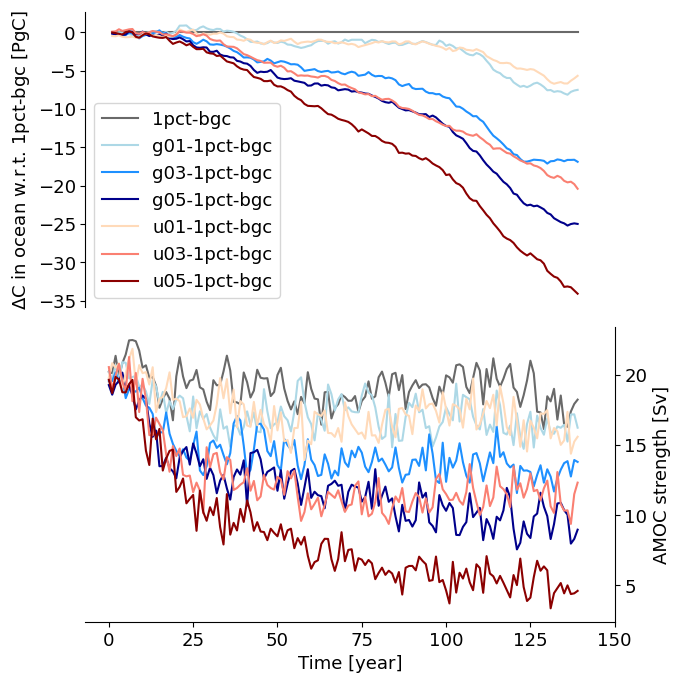

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(7,7), sharex=True)
fig.subplots_adjust(hspace=0)
plt.rcParams['font.size'] = 13

axs[0].plot(np.arange(1851, 1990), -(diff_dissic_1pctbgc-diff_dissic_1pctbgc), label ='1pct-bgc', color='dimgrey')
axs[0].plot(np.arange(1851, 1990), -(diff_dissic_1pctbgc-diff_dissic_g011pctbgc), label ='g01-1pct-bgc', color='lightblue')
axs[0].plot(np.arange(1851, 1990), -(diff_dissic_1pctbgc-diff_dissic_g031pctbgc), label ='g03-1pct-bgc', color='dodgerblue')
axs[0].plot(np.arange(1851, 1990), -(diff_dissic_1pctbgc-diff_dissic_g051pctbgc), label ='g05-1pct-bgc', color='darkblue')
axs[0].plot(np.arange(1851, 1990), -(diff_dissic_1pctbgc-diff_dissic_u011pctbgc), label ='u01-1pct-bgc', color='peachpuff')
axs[0].plot(np.arange(1851, 1990), -(diff_dissic_1pctbgc-diff_dissic_u031pctbgc), label ='u03-1pct-bgc', color='salmon')
axs[0].plot(np.arange(1851, 1990), -(diff_dissic_1pctbgc-diff_dissic_u051pctbgc), label ='u05-1pct-bgc', color='darkred')
axs[0].set_ylabel('$\Delta$C in ocean w.r.t. 1pct-bgc [PgC]')
axs[0].set_title("")
axs[0].set_xlabel("")
axs[0].tick_params(axis='y')
axs[0].spines['bottom'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_xticks([])
axs[0].get_xaxis().set_visible(False)
axs[0].legend(loc=3)

(ds_msftmz_1pctbgc.isel(basin=1).sel(lat=26.5).sel(lev=1020).groupby('time.year').mean('time').msftmz/1e9).plot(ax=axs[1], color='dimgrey', label ='1pct-bgc')
(ds_msftmz_g011pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[1], color='lightblue', label ='g01-1pct-bgc')
(ds_msftmz_g031pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[1], color='dodgerblue', label ='g03-1pct-bgc')
(ds_msftmz_g051pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[1], color='darkblue', label ='g05-1pct-bgc')
(ds_msftmz_u011pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[1], color='peachpuff', label ='u01-1pct-bgc')
(ds_msftmz_u031pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[1], color='salmon', label ='u03-1pct-bgc')
(ds_msftmz_u051pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[1], color='darkred', label ='u05-1pct-bgc')
axs[1].set_ylabel("AMOC strength [Sv]")
axs[1].tick_params(axis='y')
axs[1].spines['left'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].set_xlabel("Time [year]")
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_title("")
axs[1].set_xticks([1850, 1875, 1900, 1925, 1950, 1975, 2000], [0, 25, 50, 75, 100, 125, 150])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()
#plt.savefig('../plots/hosing_amoc_carbon_timeseries.png', transparent=True)

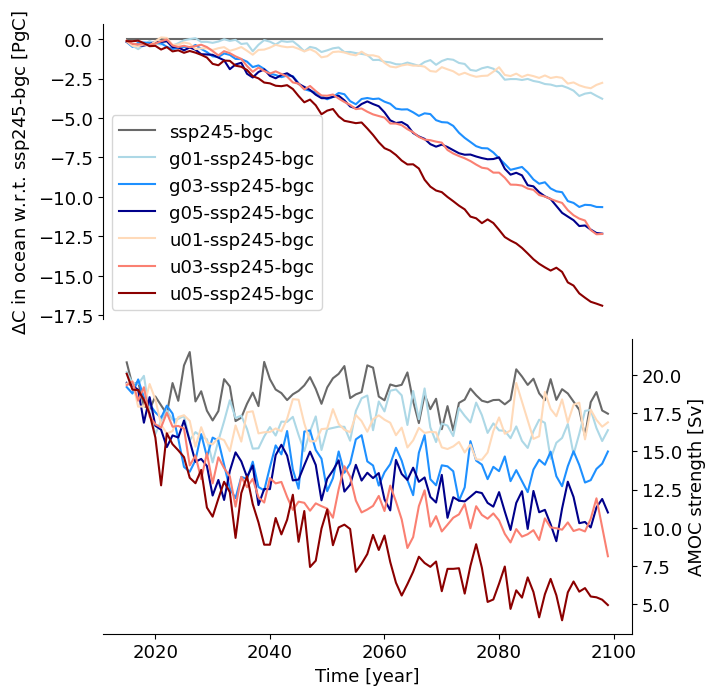

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(7,7), sharex=True)
fig.subplots_adjust(hspace=0)
plt.rcParams['font.size'] = 13

axs[0].plot(np.arange(2015, 2099), -(diff_dissic_ssp245bgc-diff_dissic_ssp245bgc), label ='ssp245-bgc', color='dimgrey')
axs[0].plot(np.arange(2015, 2099), -(diff_dissic_ssp245bgc-diff_dissic_g01ssp245bgc), label ='g01-ssp245-bgc', color='lightblue')
axs[0].plot(np.arange(2015, 2099), -(diff_dissic_ssp245bgc-diff_dissic_g03ssp245bgc), label ='g03-ssp245-bgc', color='dodgerblue')
axs[0].plot(np.arange(2015, 2099), -(diff_dissic_ssp245bgc-diff_dissic_g05ssp245bgc), label ='g05-ssp245-bgc', color='darkblue')
axs[0].plot(np.arange(2015, 2099), -(diff_dissic_ssp245bgc-diff_dissic_u01ssp245bgc), label ='u01-ssp245-bgc', color='peachpuff')
axs[0].plot(np.arange(2015, 2099), -(diff_dissic_ssp245bgc-diff_dissic_u03ssp245bgc), label ='u03-ssp245-bgc', color='salmon')
axs[0].plot(np.arange(2015, 2099), -(diff_dissic_ssp245bgc-diff_dissic_u05ssp245bgc), label ='u05-ssp245-bgc', color='darkred')
axs[0].set_ylabel('$\Delta$C in ocean w.r.t. ssp245-bgc [PgC]')
axs[0].set_title("")
axs[0].set_xlabel("")
axs[0].tick_params(axis='y')
axs[0].spines['bottom'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_xticks([])
axs[0].get_xaxis().set_visible(False)
axs[0].legend(loc=3)

(ds_msftmz_ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[1], color='dimgrey', label ='ssp245-bgc')
(ds_msftmz_g01ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[1], color='lightblue', label ='g01-ssp245-bgc')
(ds_msftmz_g03ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[1], color='dodgerblue', label ='g03-ssp245-bgc')
(ds_msftmz_g05ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[1], color='darkblue', label ='g05-ssp245-bgc')
(ds_msftmz_u01ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[1], color='peachpuff', label ='u01-ssp245-bgc')
(ds_msftmz_u03ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[1], color='salmon', label ='u03-ssp245-bgc')
(ds_msftmz_u05ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[1], color='darkred', label ='u05-ssp245-bgc')
axs[1].set_ylabel("AMOC strength [Sv]")
axs[1].tick_params(axis='y')
axs[1].spines['left'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].set_xlabel("Time [year]")
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_title("")
axs[1].set_xticks([2020, 2040, 2060, 2080, 2100], [2020, 2040, 2060, 2080, 2100])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()
#plt.savefig('../plots/hosing_amoc_carbon_timeseries.png', transparent=True)

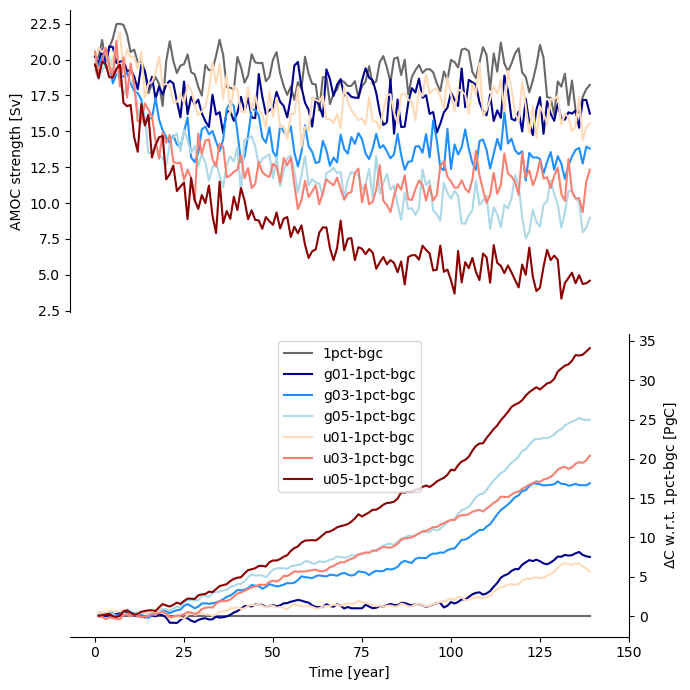

In [67]:
fig, axs = plt.subplots(2, 1, figsize=(7,7), sharex=True)
fig.subplots_adjust(hspace=0)

(ds_msftmz_1pctbgc.isel(basin=1).sel(lat=26.5).sel(lev=1020).groupby('time.year').mean('time').msftmz/1e9).plot(ax=axs[0], color='dimgrey', label ='1pct-bgc')
(ds_msftmz_g011pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[0], color='darkblue', label ='g01-1pct-bgc')
(ds_msftmz_g031pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[0], color='dodgerblue', label ='g03-1pct-bgc')
(ds_msftmz_g051pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[0], color='lightblue', label ='g05-1pct-bgc')
(ds_msftmz_u011pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[0], color='peachpuff', label ='u01-1pct-bgc')
(ds_msftmz_u031pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[0], color='salmon', label ='u03-1pct-bgc')
(ds_msftmz_u051pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).plot(ax=axs[0], color='darkred', label ='u05-1pct-bgc')
#axs[0].legend(loc='lower center')
axs[0].set_title("")
axs[0].set_xlabel("")
axs[0].set_ylabel("AMOC strength [Sv]")
axs[0].tick_params(axis='y')
axs[0].spines['bottom'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_xticks([])
axs[0].get_xaxis().set_visible(False)

axs[1].plot(np.arange(1851, 1990), diff_dissic_1pctbgc-diff_dissic_1pctbgc, label ='1pct-bgc', color='dimgrey')
axs[1].plot(np.arange(1851, 1990), diff_dissic_1pctbgc-diff_dissic_g011pctbgc, label ='g01-1pct-bgc', color='darkblue')
axs[1].plot(np.arange(1851, 1990), diff_dissic_1pctbgc-diff_dissic_g031pctbgc, label ='g03-1pct-bgc', color='dodgerblue')
axs[1].plot(np.arange(1851, 1990), diff_dissic_1pctbgc-diff_dissic_g051pctbgc, label ='g05-1pct-bgc', color='lightblue')
axs[1].plot(np.arange(1851, 1990), diff_dissic_1pctbgc-diff_dissic_u011pctbgc, label ='u01-1pct-bgc', color='peachpuff')
axs[1].plot(np.arange(1851, 1990), diff_dissic_1pctbgc-diff_dissic_u031pctbgc, label ='u03-1pct-bgc', color='salmon')
axs[1].plot(np.arange(1851, 1990), diff_dissic_1pctbgc-diff_dissic_u051pctbgc, label ='u05-1pct-bgc', color='darkred')
axs[1].tick_params(axis='y')
axs[1].set_ylabel('$\Delta$C w.r.t. 1pct-bgc [PgC]')
axs[1].spines['left'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].set_xlabel("Time [year]")
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_title("")
axs[1].legend(loc='upper center')
axs[1].set_xticks([1850, 1875, 1900, 1925, 1950, 1975, 2000], [0, 25, 50, 75, 100, 125, 150])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()
#plt.savefig('../plots/hosing_amoc_carbon_timeseries.png', transparent=True)

In [64]:
diff_dissic_u051pctbgc_array=[]
diff_dissic_u031pctbgc_array=[]
diff_dissic_u011pctbgc_array=[]
diff_dissic_g051pctbgc_array=[]
diff_dissic_g031pctbgc_array=[]
diff_dissic_g011pctbgc_array=[]
diff_dissic_1pctbgc_array=[]
for i in range(len(diff_dissic_u051pctbgc)):
    diff_dissic_u051pctbgc_array.append(diff_dissic_u051pctbgc[i].item())
    diff_dissic_u031pctbgc_array.append(diff_dissic_u031pctbgc[i].item())
    diff_dissic_u011pctbgc_array.append(diff_dissic_u011pctbgc[i].item())
    diff_dissic_g011pctbgc_array.append(diff_dissic_g011pctbgc[i].item())
    diff_dissic_g031pctbgc_array.append(diff_dissic_g031pctbgc[i].item())
    diff_dissic_g051pctbgc_array.append(diff_dissic_g051pctbgc[i].item())
    diff_dissic_1pctbgc_array.append(diff_dissic_1pctbgc[i].item())

In [32]:
diff_dissic_u05ssp245bgc_array=[]
diff_dissic_u03ssp245bgc_array=[]
diff_dissic_u01ssp245bgc_array=[]
diff_dissic_g05ssp245bgc_array=[]
diff_dissic_g03ssp245bgc_array=[]
diff_dissic_g01ssp245bgc_array=[]
diff_dissic_ssp245bgc_array=[]
for i in range(len(diff_dissic_u05ssp245bgc)):
    diff_dissic_u05ssp245bgc_array.append(diff_dissic_u05ssp245bgc[i].item())
    diff_dissic_u03ssp245bgc_array.append(diff_dissic_u03ssp245bgc[i].item())
    diff_dissic_u01ssp245bgc_array.append(diff_dissic_u01ssp245bgc[i].item())
    diff_dissic_g01ssp245bgc_array.append(diff_dissic_g01ssp245bgc[i].item())
    diff_dissic_g03ssp245bgc_array.append(diff_dissic_g03ssp245bgc[i].item())
    diff_dissic_g05ssp245bgc_array.append(diff_dissic_g05ssp245bgc[i].item())
    diff_dissic_ssp245bgc_array.append(diff_dissic_ssp245bgc[i].item())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


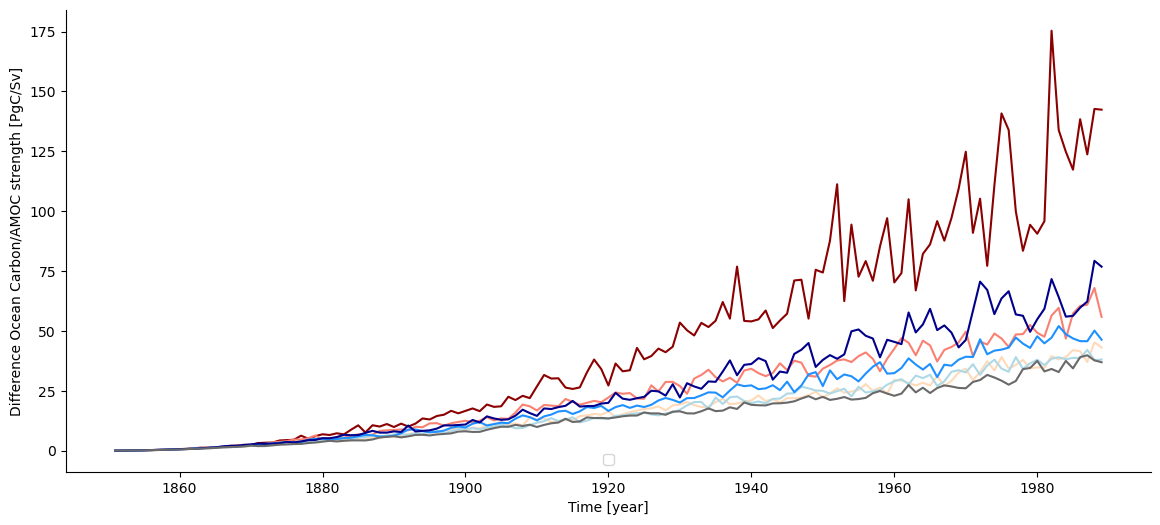

In [68]:
fig, axs = plt.subplots(figsize=(14, 6))
axs.plot(np.arange(1851, 1990), diff_dissic_u051pctbgc_array/(ds_msftmz_u051pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').isel(year=np.arange(0,139)).atlantic_moc.values/1e9), color='darkred')
axs.plot(np.arange(1851, 1990), diff_dissic_u031pctbgc_array/(ds_msftmz_u031pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').isel(year=np.arange(0,139)).atlantic_moc.values/1e9), color='salmon')
axs.plot(np.arange(1851, 1990), diff_dissic_u011pctbgc_array/(ds_msftmz_u011pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').isel(year=np.arange(0,139)).atlantic_moc.values/1e9), color='peachpuff')
axs.plot(np.arange(1851, 1990), diff_dissic_g011pctbgc_array/(ds_msftmz_g011pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').isel(year=np.arange(0,139)).atlantic_moc.values/1e9), color='lightblue')
axs.plot(np.arange(1851, 1990), diff_dissic_g031pctbgc_array/(ds_msftmz_g031pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').isel(year=np.arange(0,139)).atlantic_moc.values/1e9), color='dodgerblue')
axs.plot(np.arange(1851, 1990), diff_dissic_g051pctbgc_array/(ds_msftmz_g051pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').isel(year=np.arange(0,139)).atlantic_moc.values/1e9), color='darkblue')
axs.plot(np.arange(1851, 1990), diff_dissic_1pctbgc_array/(ds_msftmz_1pctbgc.sel(lat=26.5).sel(lev=1020).isel(basin=1).groupby('time.year').mean('time').isel(year=np.arange(0,139)).msftmz.values/1e9), color='dimgrey')
axs.legend(loc='lower center')
axs.set_ylabel('Difference Ocean Carbon/AMOC strength [PgC/Sv]', color='k')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_xlabel("Time [year]")
plt.show()

# Export data to csv

## 1pct-bgc

In [125]:
(ds_dissic_u051pctbgcLR.dissic*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth').sum(dim='y').sum(dim='x').values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_dissic_u051pctbgcLR.csv', sep=',')

In [126]:
(ds_dissic_u031pctbgcLR.dissic*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth').sum(dim='y').sum(dim='x').values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_dissic_u031pctbgcLR.csv', sep=',')

In [69]:
(ds_dissic_u011pctbgcLR.dissic*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth').sum(dim='y').sum(dim='x').values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_dissic_u011pctbgcLR.csv', sep=',')

In [127]:
(ds_dissic_g011pctbgcLR.dissic*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth').sum(dim='y').sum(dim='x').values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_dissic_g011pctbgcLR.csv', sep=',')

In [8]:
(ds_dissic_g031pctbgcLR.dissic*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth').sum(dim='y').sum(dim='x').values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_dissic_g031pctbgcLR.csv', sep=',')

In [70]:
(ds_dissic_g051pctbgcLR.dissic*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth').sum(dim='y').sum(dim='x').values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_dissic_g051pctbgcLR.csv', sep=',')

In [57]:
(ds_dissic_1pctbgc.groupby('time.year').mean().dissic*ds_volcello.volcello*g_per_molC/1e15).isel(lev=np.arange(0,40)).sum(dim='lev').sum(dim='i').sum(dim='j').values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_dissic_1pctbgcLR.csv', sep=',')

In [ ]:
Dissic diff

In [121]:
np.array(diff_dissic_u051pctbgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_dissic_u051pctbgcLR.csv', sep=',')

In [122]:
np.array(diff_dissic_u031pctbgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_dissic_u031pctbgcLR.csv', sep=',')

In [71]:
np.array(diff_dissic_u011pctbgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_dissic_u011pctbgcLR.csv', sep=',')

In [123]:
np.array(diff_dissic_g011pctbgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_dissic_g011pctbgcLR.csv', sep=',')

In [15]:
np.array(diff_dissic_g031pctbgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_dissic_g031pctbgcLR.csv', sep=',')

In [72]:
np.array(diff_dissic_g051pctbgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_dissic_g051pctbgcLR.csv', sep=',')

In [124]:
np.array(diff_dissic_1pctbgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_dissic_1pctbgcLR.csv', sep=',')

In [ ]:
msftmz totals 

In [117]:
(ds_msftmz_u051pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_amoc26.5N_u051pctbgcLR.csv', sep=',')

In [118]:
(ds_msftmz_u031pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_amoc26.5N_u031pctbgcLR.csv', sep=',')

In [74]:
(ds_msftmz_u011pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_amoc26.5N_u011pctbgcLR.csv', sep=',')

In [119]:
(ds_msftmz_g011pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_amoc26.5N_g011pctbgcLR.csv', sep=',')

In [22]:
(ds_msftmz_g031pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_amoc26.5N_g031pctbgcLR.csv', sep=',')

In [73]:
(ds_msftmz_g051pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_amoc26.5N_g051pctbgcLR.csv', sep=',')

In [120]:
(ds_msftmz_1pctbgc.isel(basin=1).sel(lat=26.5).sel(lev=1020).groupby('time.year').mean('time').msftmz/1e9).values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_amoc26.5N_1pctbgcLR.csv', sep=',')

In [ ]:
msftmz diff

In [75]:
ds_msftmz_u051pctbgcLR.load()
ds_msftmz_u031pctbgcLR.load()
ds_msftmz_u011pctbgcLR.load()
ds_msftmz_g011pctbgcLR.load()
ds_msftmz_g031pctbgcLR.load()
ds_msftmz_g011pctbgcLR.load()
ds_msftmz_1pctbgc.load()

<xarray.Dataset>
Dimensions:    (time: 1680, bnds: 2, basin: 3, lev: 41, lat: 180)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 1989-12-16 12:00:00
    sector     (basin) |S21 b'global_ocean         ' ... b'indian_pacific_oce...
  * lev        (lev) float64 0.0 12.0 22.0 32.0 ... 4.92e+03 5.42e+03 6.02e+03
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds, basin
Data variables:
    time_bnds  (time, bnds) object 1850-01-01 00:00:00 ... 1990-01-01 00:00:00
    lev_bnds   (time, lev, bnds) float64 0.0 6.0 6.0 ... 5.72e+03 6.02e+03
    lat_bnds   (time, lat, bnds) float64 -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
    msftmz     (time, basin, lev, lat) float32 nan nan nan nan ... nan nan nan
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-LR output prepared for CMIP6
    variable_id:            msftmz
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/366becb1-8ec0-4f3e-9704-3ef89cdeded6

In [76]:
# not the same as msftmt_..._diff, which just calculate the total difference at the end of the period
from tqdm import tqdm
diff_msftmz_u051pctbgc = []
diff_msftmz_u031pctbgc = []
diff_msftmz_u011pctbgc = []
diff_msftmz_g011pctbgc = []
diff_msftmz_g031pctbgc = []
diff_msftmz_g051pctbgc = []
diff_msftmz_1pctbgc    = []
amoc26_u051pctbgc_yearly = ds_msftmz_u051pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time')
amoc26_u031pctbgc_yearly = ds_msftmz_u031pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time')
amoc26_u011pctbgc_yearly = ds_msftmz_u011pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time')
amoc26_g011pctbgc_yearly = ds_msftmz_g011pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time')
amoc26_g031pctbgc_yearly = ds_msftmz_g031pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time')
amoc26_g051pctbgc_yearly = ds_msftmz_g051pctbgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time')
amoc26_1pctbgc_yearly = ds_msftmz_1pctbgc.sel(lat=26.5).sel(lev=1020).isel(basin=1).groupby('time.year').mean('time')

for year in tqdm(range(1,140)): 
    diff_msftmz_u051pctbgc.append(
        ((amoc26_u051pctbgc_yearly.isel(year=np.arange(year,year+1)).atlantic_moc.values)/1e9)
        -((amoc26_u051pctbgc_yearly.isel(year=0).atlantic_moc.values)/1e9))
    
    diff_msftmz_u031pctbgc.append(
        ((amoc26_u031pctbgc_yearly.isel(year=np.arange(year,year+1)).atlantic_moc.values)/1e9)
        -((amoc26_u031pctbgc_yearly.isel(year=0).atlantic_moc.values)/1e9))
    
    diff_msftmz_u011pctbgc.append(
        ((amoc26_u011pctbgc_yearly.isel(year=np.arange(year,year+1)).atlantic_moc.values)/1e9)
        -((amoc26_u011pctbgc_yearly.isel(year=0).atlantic_moc.values)/1e9))
    
    diff_msftmz_g011pctbgc.append(
        ((amoc26_g011pctbgc_yearly.isel(year=np.arange(year,year+1)).atlantic_moc.values)/1e9)
        -((amoc26_g011pctbgc_yearly.isel(year=0).atlantic_moc.values)/1e9))
    
    diff_msftmz_g031pctbgc.append(
        ((amoc26_g031pctbgc_yearly.isel(year=np.arange(year,year+1)).atlantic_moc.values)/1e9)
        -((amoc26_g031pctbgc_yearly.isel(year=0).atlantic_moc.values)/1e9))
    
    diff_msftmz_g051pctbgc.append(
        ((amoc26_g051pctbgc_yearly.isel(year=np.arange(year,year+1)).atlantic_moc.values)/1e9)
        -((amoc26_g051pctbgc_yearly.isel(year=0).atlantic_moc.values)/1e9))
    
    diff_msftmz_1pctbgc.append(
        ((amoc26_1pctbgc_yearly.isel(year=np.arange(year,year+1)).msftmz.values)/1e9)
        -((amoc26_1pctbgc_yearly.isel(year=0).msftmz.values)/1e9))

100%|██████████| 139/139 [00:12<00:00, 11.46it/s]


In [77]:
diff_amoc26_u051pctbgc_array=[]
diff_amoc26_u031pctbgc_array=[]
diff_amoc26_u011pctbgc_array=[]
diff_amoc26_g011pctbgc_array=[]
diff_amoc26_g031pctbgc_array=[]
diff_amoc26_g051pctbgc_array=[]
diff_amoc26_1pctbgc_array=[]
for i in range(len(diff_msftmz_u051pctbgc)):
    diff_amoc26_u051pctbgc_array.append(diff_msftmz_u051pctbgc[i].item())
    diff_amoc26_u031pctbgc_array.append(diff_msftmz_u031pctbgc[i].item())
    diff_amoc26_u011pctbgc_array.append(diff_msftmz_u011pctbgc[i].item())
    diff_amoc26_g011pctbgc_array.append(diff_msftmz_g011pctbgc[i].item())
    diff_amoc26_g031pctbgc_array.append(diff_msftmz_g031pctbgc[i].item())
    diff_amoc26_g051pctbgc_array.append(diff_msftmz_g051pctbgc[i].item())
    diff_amoc26_1pctbgc_array.append(diff_msftmz_1pctbgc[i].item())

In [134]:
np.array(diff_amoc26_u051pctbgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_amoc26.5N_u051pctbgcLR.csv', sep=',')

In [135]:
np.array(diff_amoc26_u031pctbgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_amoc26.5N_u031pctbgcLR.csv', sep=',')

In [78]:
np.array(diff_amoc26_u011pctbgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_amoc26.5N_u011pctbgcLR.csv', sep=',')

In [136]:
np.array(diff_amoc26_g011pctbgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_amoc26.5N_g011pctbgcLR.csv', sep=',')

In [21]:
np.array(diff_amoc26_g031pctbgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_amoc26.5N_g031pctbgcLR.csv', sep=',')

In [79]:
np.array(diff_amoc26_g051pctbgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_amoc26.5N_g051pctbgcLR.csv', sep=',')

In [137]:
np.array(diff_amoc26_1pctbgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_amoc26.5N_1pctbgcLR.csv', sep=',')

In [142]:
amoc26_u051pctbgc_yearly.year.values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/time.csv', sep=',')

In [138]:
import csv
with open('/work/uo1075/m300817/carbon_amoc/files/diff_amoc26.5N_1pctbgcLR.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
data_array = np.array(data)

## ssp245-bgc

Dissic totals

In [ ]:
(ds_dissic_u05ssp245bgcLR.dissic*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth').sum(dim='y').sum(dim='x').values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_dissic_u05ssp245bgcLR.csv', sep=',')

(ds_dissic_u03ssp245bgcLR.dissic*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth').sum(dim='y').sum(dim='x').values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_dissic_u03ssp245bgcLR.csv', sep=',')

(ds_dissic_u01ssp245bgcLR.dissic*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth').sum(dim='y').sum(dim='x').values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_dissic_u01ssp245bgcLR.csv', sep=',')

(ds_dissic_g01ssp245bgcLR.dissic*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth').sum(dim='y').sum(dim='x').values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_dissic_g01ssp245bgcLR.csv', sep=',')

(ds_dissic_g03ssp245bgcLR.dissic*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth').sum(dim='y').sum(dim='x').values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_dissic_g03ssp245bgcLR.csv', sep=',')

(ds_dissic_g05ssp245bgcLR.dissic*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth').sum(dim='y').sum(dim='x').values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_dissic_g05ssp245bgcLR.csv', sep=',')

(ds_dissic_ssp245bgcLR.dissic*ds_volcello_u05hosLR.sum(dim="time").volcello*g_per_molC/1e15).isel(depth=np.arange(0,40)).sum(dim='depth').sum(dim='y').sum(dim='x').values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_dissic_ssp245bgcLR.csv', sep=',')

Dissic diff

In [ ]:
np.array(diff_dissic_u05ssp245bgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_dissic_u05ssp245bgcLR.csv', sep=',')

np.array(diff_dissic_u03ssp245bgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_dissic_u03ssp245bgcLR.csv', sep=',')

np.array(diff_dissic_u01ssp245bgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_dissic_u01ssp245bgcLR.csv', sep=',')

np.array(diff_dissic_g01ssp245bgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_dissic_g01ssp245bgcLR.csv', sep=',')

np.array(diff_dissic_g03ssp245bgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_dissic_g03ssp245bgcLR.csv', sep=',')

np.array(diff_dissic_g05ssp245bgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_dissic_g05ssp245bgcLR.csv', sep=',')

np.array(diff_dissic_ssp245bgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_dissic_ssp245bgcLR.csv', sep=',')

msftmz totals 

In [ ]:
(ds_msftmz_u05ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_amoc26.5N_u05ssp245bgcLR.csv', sep=',')

(ds_msftmz_u03ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_amoc26.5N_u03ssp245bgcLR.csv', sep=',')

(ds_msftmz_u01ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_amoc26.5N_u01ssp245bgcLR.csv', sep=',')(ds_msftmz_g01ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_amoc26.5N_g01ssp245bgcLR.csv', sep=',')

(ds_msftmz_g03ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_amoc26.5N_g03ssp245bgcLR.csv', sep=',')

(ds_msftmz_g05ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_amoc26.5N_g05ssp245bgcLR.csv', sep=',')

(ds_msftmz_ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time').atlantic_moc/1e9).values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/total_amoc26.5N_ssp245bgcLR.csv', sep=',')

msftmz diff

In [50]:
ds_msftmz_u05ssp245bgcLR.load()
ds_msftmz_u03ssp245bgcLR.load()
ds_msftmz_u01ssp245bgcLR.load()
ds_msftmz_g01ssp245bgcLR.load()
ds_msftmz_g03ssp245bgcLR.load()
ds_msftmz_g01ssp245bgcLR.load()
ds_msftmz_ssp245bgcLR.load()

<xarray.Dataset>
Dimensions:                    (lon: 1, lat: 180, depth: 1, depth_2: 41,
                                time: 1020)
Coordinates:
  * lon                        (lon) float64 0.0
  * lat                        (lat) float64 -89.5 -88.5 -87.5 ... 88.5 89.5
  * depth                      (depth) float64 0.0
  * depth_2                    (depth_2) float64 0.0 12.0 ... 5.42e+03 6.02e+03
  * time                       (time) object 2015-01-31 23:15:00 ... 2099-12-...
Data variables: (12/24)
    global_hfl                 (time, depth, lat, lon) float32 -4.753e+15 ......
    atlantic_hfl               (time, depth, lat, lon) float32 2.869e+15 ... ...
    indopacific_hfl            (time, depth, lat, lon) float32 -7.622e+15 ......
    global_wfl                 (time, depth, lat, lon) float32 6.903e+05 ... ...
    atlantic_wfl               (time, depth, lat, lon) float32 8.308e+05 ... ...
    indopacific_wfl            (time, depth, lat, lon) float32 -1.405e+05 ......
    ...                         ...
    global_hfbasinpmdiff       (time, depth, lat, lon) float32 -2.766e+06 ......
    atlantic_hfbasinpmdiff     (time, depth, lat, lon) float32 -4.33e+12 ... ...
    indopacific_hfbasinpmdiff  (time, depth, lat, lon) float32 4.33e+12 ... 0.0
    global_sltbasin            (time, depth, lat, lon) float32 4.14e+07 ... 5...
    atlantic_sltbasin          (time, depth, lat, lon) float32 4.036e+07 ... ...
    indopacific_sltbasin       (time, depth, lat, lon) float32 1.039e+06 ... 0.0
Attributes:
    CDI:          Climate Data Interface version 1.7.0rc3 (http://mpimet.mpg....
    Conventions:  CF-1.4
    MPIOM:        $Revision: 8637eee7f023c05182230a042556b592d81c679c $

In [51]:
# not the same as msftmt_..._diff, which just calculate the total difference at the end of the period
from tqdm import tqdm
diff_msftmz_u05ssp245bgc = []
diff_msftmz_u03ssp245bgc = []
diff_msftmz_u01ssp245bgc = []
diff_msftmz_g01ssp245bgc = []
diff_msftmz_g03ssp245bgc = []
diff_msftmz_g05ssp245bgc = []
diff_msftmz_ssp245bgc    = []
amoc26_u05ssp245bgc_yearly = ds_msftmz_u05ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time')
amoc26_u03ssp245bgc_yearly = ds_msftmz_u03ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time')
amoc26_u01ssp245bgc_yearly = ds_msftmz_u01ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time')
amoc26_g01ssp245bgc_yearly = ds_msftmz_g01ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time')
amoc26_g03ssp245bgc_yearly = ds_msftmz_g03ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time')
amoc26_g05ssp245bgc_yearly = ds_msftmz_g05ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time')
amoc26_ssp245bgc_yearly = ds_msftmz_ssp245bgcLR.sel(lat=26.5).sel(depth_2=1020).sel(lon=0).groupby('time.year').mean('time')
for year in tqdm(range(1,85)): 
    diff_msftmz_u05ssp245bgc.append(
        ((amoc26_u05ssp245bgc_yearly.isel(year=np.arange(year,year+1)).atlantic_moc.values)/1e9)
        -((amoc26_u05ssp245bgc_yearly.isel(year=0).atlantic_moc.values)/1e9))
    
    diff_msftmz_u03ssp245bgc.append(
        ((amoc26_u03ssp245bgc_yearly.isel(year=np.arange(year,year+1)).atlantic_moc.values)/1e9)
        -((amoc26_u03ssp245bgc_yearly.isel(year=0).atlantic_moc.values)/1e9))
    
    diff_msftmz_u01ssp245bgc.append(
        ((amoc26_u01ssp245bgc_yearly.isel(year=np.arange(year,year+1)).atlantic_moc.values)/1e9)
        -((amoc26_u01ssp245bgc_yearly.isel(year=0).atlantic_moc.values)/1e9))
    
    diff_msftmz_g01ssp245bgc.append(
        ((amoc26_g01ssp245bgc_yearly.isel(year=np.arange(year,year+1)).atlantic_moc.values)/1e9)
        -((amoc26_g01ssp245bgc_yearly.isel(year=0).atlantic_moc.values)/1e9))
    
    diff_msftmz_g03ssp245bgc.append(
        ((amoc26_g03ssp245bgc_yearly.isel(year=np.arange(year,year+1)).atlantic_moc.values)/1e9)
        -((amoc26_g03ssp245bgc_yearly.isel(year=0).atlantic_moc.values)/1e9))
    
    diff_msftmz_g05ssp245bgc.append(
        ((amoc26_g05ssp245bgc_yearly.isel(year=np.arange(year,year+1)).atlantic_moc.values)/1e9)
        -((amoc26_g05ssp245bgc_yearly.isel(year=0).atlantic_moc.values)/1e9))
    
    diff_msftmz_ssp245bgc.append(
        ((amoc26_ssp245bgc_yearly.isel(year=np.arange(year,year+1)).atlantic_moc.values)/1e9)
        -((amoc26_ssp245bgc_yearly.isel(year=0).atlantic_moc.values)/1e9))
    

100%|██████████| 84/84 [00:06<00:00, 13.77it/s]


In [52]:
diff_amoc26_u05ssp245bgc_array=[]
diff_amoc26_u03ssp245bgc_array=[]
diff_amoc26_u01ssp245bgc_array=[]
diff_amoc26_g01ssp245bgc_array=[]
diff_amoc26_g03ssp245bgc_array=[]
diff_amoc26_g05ssp245bgc_array=[]
diff_amoc26_ssp245bgc_array=[]
for i in range(len(diff_msftmz_u05ssp245bgc)):
    diff_amoc26_u05ssp245bgc_array.append(diff_msftmz_u05ssp245bgc[i].item())
    diff_amoc26_u03ssp245bgc_array.append(diff_msftmz_u03ssp245bgc[i].item())
    diff_amoc26_u01ssp245bgc_array.append(diff_msftmz_u01ssp245bgc[i].item())
    diff_amoc26_g01ssp245bgc_array.append(diff_msftmz_g01ssp245bgc[i].item())
    diff_amoc26_g03ssp245bgc_array.append(diff_msftmz_g03ssp245bgc[i].item())
    diff_amoc26_g05ssp245bgc_array.append(diff_msftmz_g05ssp245bgc[i].item())
    diff_amoc26_ssp245bgc_array.append(diff_msftmz_ssp245bgc[i].item())

In [ ]:
np.array(diff_amoc26_u05ssp245bgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_amoc26.5N_u05ssp245bgcLR.csv', sep=',')

np.array(diff_amoc26_u03ssp245bgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_amoc26.5N_u03ssp245bgcLR.csv', sep=',')

np.array(diff_amoc26_u01ssp245bgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_amoc26.5N_u01ssp245bgcLR.csv', sep=',')

np.array(diff_amoc26_g01ssp245bgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_amoc26.5N_g01ssp245bgcLR.csv', sep=',')

np.array(diff_amoc26_g03ssp245bgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_amoc26.5N_g03ssp245bgcLR.csv', sep=',')

np.array(diff_amoc26_g05ssp245bgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_amoc26.5N_g05ssp245bgcLR.csv', sep=',')

np.array(diff_amoc26_ssp245bgc_array).tofile(
    '/work/uo1075/m300817/carbon_amoc/files/diff_amoc26.5N_ssp245bgcLR.csv', sep=',')

amoc26_u05ssp245bgc_yearly.year.values.tofile(
    '/work/uo1075/m300817/carbon_amoc/files/time.csv', sep=',')

# SSPs and piC in CMIP6 models

## ssp245

In [161]:
# Paths for ssp245 scenario
paths={'MPI-ESM1.2-LR':'/work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp245/',
       'CanESM5':'/work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp245',
       'CESM2':'/work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/NCAR/CESM2/ssp245',
       'NorESM2-LM':'/work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/NCC/NorESM2-LM/ssp245',
       'ACCESS-ESM1-5':'/work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp245',
       'MIROC-ES2L': '/work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/MIROC/MIROC-ES2L/ssp245', 
       'GISS-E2-1-G': '/work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/NASA-GISS/GISS-E2-1-G//ssp245/'
      }

### MPI-ESM1.2-LR

In [178]:
array = []
for i in range(1,51):
    rea = "r"+str(i)+"i1p1f1"
    infiles = glob.glob(f'{paths["MPI-ESM1.2-LR"]}/{rea}/Omon/msftmz/gn/**/*.nc', recursive=True)
    array.append(xr.open_mfdataset(infiles, use_cftime=True, data_vars="minimal", coords="minimal", compat="override", parallel=True).assign_coords(realiz=rea))
msftmz_mpiesmlr = xr.concat(array, dim='realiz')

In [38]:
msftmz_mpiesmlr_mean = (weighted_mon_to_year_mean(msftmz_mpiesmlr.sel(lat=26.5).sel(lev=1020).isel(basin=1), 'msftmz').mean(dim="realiz"))/(1025.0 * 10**6)
msftmz_mpiesmlr_std = (weighted_mon_to_year_mean(msftmz_mpiesmlr.sel(lat=26.5).sel(lev=1020).isel(basin=1), 'msftmz').std(dim="realiz"))/(1025.0 * 10**6)

In [39]:
# Save to .nc file
ds = xr.Dataset({
    'mean': msftmz_mpiesmlr_mean,
    'std': msftmz_mpiesmlr_std
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/MPI-ESM1.2-LR/msftmz_mpiesmlr_ssp245.nc'
ds.to_netcdf(path=file_path)

3 ens members only

In [179]:
msftmz_mpiesmlr_mean = (weighted_mon_to_year_mean(msftmz_mpiesmlr.sel(lat=26.5).sel(lev=1020).isel(basin=1), 'msftmz').isel(realiz=slice(0, 3)).mean(dim="realiz"))/(1025.0 * 10**6)
msftmz_mpiesmlr_std = (weighted_mon_to_year_mean(msftmz_mpiesmlr.sel(lat=26.5).sel(lev=1020).isel(basin=1), 'msftmz').isel(realiz=slice(0, 3)).std(dim="realiz"))/(1025.0 * 10**6)

In [181]:
# Save to .nc file
ds = xr.Dataset({
    'mean': msftmz_mpiesmlr_mean,
    'std': msftmz_mpiesmlr_std
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/MPI-ESM1.2-LR/msftmz_mpiesmlr_ssp245_r1-3i1p2f1.nc'
ds.to_netcdf(path=file_path)

### CanESM5

In [53]:
array = []
for i in range(1,26):
    rea = "r"+str(i)+"i1p2f1"
    infiles = glob.glob(f'{paths["CanESM5"]}/{rea}/Omon/msftmz/gn/**/*.nc', recursive=True)
    array.append(xr.open_mfdataset(infiles, use_cftime=True, data_vars="minimal", coords="minimal", compat="override", parallel=True).assign_coords(realiz=rea))
ssp245_msftmz_canesm5 = xr.concat(array, dim='realiz')

In [95]:
year_amoc_levs= weighted_mon_to_year_mean(ssp245_msftmz_canesm5.sel(lat=26.5, method='nearest').isel(basin=0), 'msftmz').load()/(1025.0 * 10**6)
max_lev_indices=year_amoc_levs.idxmax(dim='lev')
year_amoc = year_amoc_levs.sel(lev=max_lev_indices)
ssp245_msftmz_canesm5_mean = year_amoc.mean(dim="realiz")
ssp245_msftmz_canesm5_std = year_amoc.std(dim="realiz")

In [92]:
# Save to .nc file
ds = xr.Dataset({
    'mean': ssp245_msftmz_canesm5_mean,
    'std': ssp245_msftmz_canesm5_std
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/CanESM5/msftmz_canesm5_ssp245_r1-25i1p2f1.nc'
ds.to_netcdf(path=file_path)

3 ens members only

In [109]:
ssp245_msftmz_canesm5_mean = year_amoc.isel(realiz=slice(0, 3)).mean(dim="realiz")
ssp245_msftmz_canesm5_std = year_amoc.isel(realiz=slice(0, 3)).std(dim="realiz")

In [111]:
# Save to .nc file
ds = xr.Dataset({
    'mean': ssp245_msftmz_canesm5_mean,
    'std': ssp245_msftmz_canesm5_std
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/CanESM5/msftmz_canesm5_ssp245_r1-3i1p2f1.nc'
ds.to_netcdf(path=file_path)

### CESM2

In [112]:
array = []
for i in [4, 10, 11]:
    rea = "r"+str(i)+"i1p1f1"
    infiles = glob.glob(f'{paths["CESM2"]}/{rea}/Omon/msftmz/gn/**/*.nc', recursive=True)
    array.append(xr.open_mfdataset(infiles, use_cftime=True, data_vars="minimal", coords="minimal", compat="override", parallel=True).assign_coords(realiz=rea))
ssp245_msftmz_cesm2 = xr.concat(array, dim='realiz')

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.


In [113]:
year_amoc_levs= weighted_mon_to_year_mean(ssp245_msftmz_cesm2.sel(lat=26.5, method='nearest').isel(basin=0), 'msftmz').load()/(1025.0 * 10**6)
max_lev_indices=year_amoc_levs.idxmax(dim='lev')
year_amoc = year_amoc_levs.sel(lev=max_lev_indices)
ssp245_msftmz_cesm2_mean = year_amoc.mean(dim="realiz")
ssp245_msftmz_cesm2_std = year_amoc.std(dim="realiz")

In [116]:
# Save to .nc file
ds = xr.Dataset({
    'mean': ssp245_msftmz_cesm2_mean,
    'std': ssp245_msftmz_cesm2_std
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/CESM2/msftmz_cesm2_ssp245_r4_r10_r11i1p1f1.nc'
ds.to_netcdf(path=file_path)

### NorESM2-LM

In [123]:
array = []
for i in [1, 2, 3]:
    rea = "r"+str(i)+"i1p1f1"
    infiles = glob.glob(f'{paths["NorESM2-LM"]}/{rea}/Omon/msftmz/grz/**/*.nc', recursive=True)
    array.append(xr.open_mfdataset(infiles, use_cftime=True, data_vars="minimal", coords="minimal", compat="override", parallel=True).assign_coords(realiz=rea))
ssp245_msftmz_noresm2lm = xr.concat(array, dim='realiz')

In [125]:
year_amoc_levs= weighted_mon_to_year_mean(ssp245_msftmz_noresm2lm.sel(lat=26.5, method='nearest').isel(basin=0), 'msftmz').load()/(1025.0 * 10**6)
max_lev_indices=year_amoc_levs.idxmax(dim='lev')
year_amoc = year_amoc_levs.sel(lev=max_lev_indices)
ssp245_msftmz_noresm2lm_mean = year_amoc.mean(dim="realiz")
ssp245_msftmz_noresm2lm_std = year_amoc.std(dim="realiz")

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [127]:
# Save to .nc file
ds = xr.Dataset({
    'mean': ssp245_msftmz_noresm2lm_mean,
    'std': ssp245_msftmz_noresm2lm_std
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/NorESM2-LM/msftmz_noresm2lm_ssp245_r1-3i1p1f1.nc'
ds.to_netcdf(path=file_path)

### ACCESS-ESM1-5

In [131]:
array = []
for i in [1,2,3,4,6,7,8]:
    rea = "r"+str(i)+"i1p1f1"
    infiles = glob.glob(f'{paths["ACCESS-ESM1-5"]}/{rea}/Omon/msftmz/gn/**/*.nc', recursive=True)
    array.append(xr.open_mfdataset(infiles, use_cftime=True, data_vars="minimal", coords="minimal", compat="override", parallel=True).assign_coords(realiz=rea))
ssp245_msftmz_accessesm15 = xr.concat(array, dim='realiz')

In [142]:
year_amoc_levs= weighted_mon_to_year_mean(ssp245_msftmz_accessesm15.sel(lat=26.5, method='nearest').isel(basin=0), 'msftmz').load()/(1025.0 * 10**6)
max_lev_indices=year_amoc_levs.idxmax(dim='lev')
year_amoc = year_amoc_levs.sel(lev=max_lev_indices)
ssp245_msftmz_accessesm15_mean = year_amoc.mean(dim="realiz")
ssp245_msftmz_accessesm15_std = year_amoc.std(dim="realiz")

In [143]:
# Save to .nc file
ds = xr.Dataset({
    'mean': ssp245_msftmz_accessesm15_mean,
    'std': ssp245_msftmz_accessesm15_std
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/ACCESS-ESM1-5/msftmz_accessesm15_ssp245_r1-4_6-8i1p1f1.nc'
ds.to_netcdf(path=file_path)

3 ens members only

In [146]:
ssp245_msftmz_accessesm15_mean = year_amoc.isel(realiz=slice(0, 3)).mean(dim="realiz")
ssp245_msftmz_accessesm15_std = year_amoc.isel(realiz=slice(0, 3)).std(dim="realiz")

In [148]:
# Save to .nc file
ds = xr.Dataset({
    'mean': ssp245_msftmz_accessesm15_mean,
    'std': ssp245_msftmz_accessesm15_std
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/ACCESS-ESM1-5/msftmz_accessesm15_ssp245_r1-3i1p1f1.nc'
ds.to_netcdf(path=file_path)

### MIROC-ES2L

In [165]:
array = []
for i in range(1,31):
    rea = "r"+str(i)+"i1p1f2"
    infiles = glob.glob(f'{paths["MIROC-ES2L"]}/{rea}/Omon/msftmz/gr/**/*.nc', recursive=True)
    array.append(xr.open_mfdataset(infiles, use_cftime=True, data_vars="minimal", coords="minimal", compat="override", parallel=True).assign_coords(realiz=rea))
ssp245_msftmz_miroces2l = xr.concat(array, dim='realiz')

In [166]:
year_amoc_levs= weighted_mon_to_year_mean(ssp245_msftmz_miroces2l.sel(lat=26.5, method='nearest').isel(basin=0), 'msftmz').load()/(1025.0 * 10**6)
max_lev_indices=year_amoc_levs.idxmax(dim='lev')
year_amoc = year_amoc_levs.sel(lev=max_lev_indices)
ssp245_msftmz_miroces2l_mean = year_amoc.mean(dim="realiz")
ssp245_msftmz_miroces2l_std = year_amoc.std(dim="realiz")

In [155]:
# Save to .nc file
ds = xr.Dataset({
    'mean': ssp245_msftmz_miroces2l_mean,
    'std': ssp245_msftmz_miroces2l_std
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/MIROC-ES2L/msftmz_miroces2l_ssp245_r1-30i1p1f2.nc'
ds.to_netcdf(path=file_path)

3 ens members only

In [158]:
ssp245_msftmz_miroces2l_mean = year_amoc.isel(realiz=slice(0, 3)).mean(dim="realiz")
ssp245_msftmz_miroces2l_std = year_amoc.isel(realiz=slice(0, 3)).std(dim="realiz")

In [160]:
# Save to .nc file
ds = xr.Dataset({
    'mean': ssp245_msftmz_miroces2l_mean,
    'std': ssp245_msftmz_miroces2l_std
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/MIROC-ES2L/msftmz_miroces2l_ssp245_r1-3i1p1f2.nc'
ds.to_netcdf(path=file_path)

### GISS-E2-1-G

In [168]:
array = []
for i in range(2,11):
    rea = "r"+str(i)+"i1p1f2"
    infiles = glob.glob(f'{paths["GISS-E2-1-G"]}/{rea}/Omon/msftmz/gn/**/*.nc', recursive=True)
    array.append(xr.open_mfdataset(infiles, use_cftime=True, data_vars="minimal", coords="minimal", compat="override", parallel=True).assign_coords(realiz=rea))
ssp245_msftmz_gisse21g = xr.concat(array, dim='realiz')

In [169]:
year_amoc_levs= weighted_mon_to_year_mean(ssp245_msftmz_gisse21g.sel(lat=26.5, method='nearest').isel(basin=0), 'msftmz').load()/(1025.0 * 10**6)
max_lev_indices=year_amoc_levs.idxmax(dim='lev')
year_amoc = year_amoc_levs.sel(lev=max_lev_indices)
ssp245_msftmz_gisse21g_mean = year_amoc.mean(dim="realiz")
ssp245_msftmz_gisse21g_std = year_amoc.std(dim="realiz")

In [172]:
# Save to .nc file
ds = xr.Dataset({
    'mean': ssp245_msftmz_gisse21g_mean,
    'std': ssp245_msftmz_gisse21g_std
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/GISS-E2-1-G/msftmz_gisse21g_ssp245_r2-10i1p1f2.nc'
ds.to_netcdf(path=file_path)

3 ens members only

In [175]:
ssp245_msftmz_gisse21g_mean = year_amoc.isel(realiz=slice(0, 3)).mean(dim="realiz")
ssp245_msftmz_gisse21g_std = year_amoc.isel(realiz=slice(0, 3)).std(dim="realiz")

In [177]:
# Save to .nc file
ds = xr.Dataset({
    'mean': ssp245_msftmz_gisse21g_mean,
    'std': ssp245_msftmz_gisse21g_std
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/GISS-E2-1-G/msftmz_gisse21g_ssp245_r2-4i1p1f2.nc'
ds.to_netcdf(path=file_path)

## ssp126

In [6]:
# Paths for ssp245 scenario
paths={'MPI-ESM1.2-LR':'/work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp126/',
      'NorESM2-LM':'/work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/NCC/NorESM2-LM/ssp126',
      }

### MPI-ESM1.2-LR

In [41]:
array = []
for i in range(1,51):
    rea = "r"+str(i)+"i1p1f1"
    infiles = glob.glob(f'{paths["MPI-ESM1.2-LR"]}/{rea}/Omon/msftmz/gn/**/*.nc', recursive=True)
    array.append(xr.open_mfdataset(infiles, use_cftime=True, data_vars="minimal", coords="minimal", compat="override", parallel=True).assign_coords(realiz=rea))
msftmz_mpiesmlr = xr.concat(array, dim='realiz')

In [42]:
msftmz_mpiesmlr_mean = (weighted_mon_to_year_mean(msftmz_mpiesmlr.sel(lat=26.5).sel(lev=1020).isel(basin=1), 'msftmz').mean(dim="realiz"))/(1025.0 * 10**6)
msftmz_mpiesmlr_std = (weighted_mon_to_year_mean(msftmz_mpiesmlr.sel(lat=26.5).sel(lev=1020).isel(basin=1), 'msftmz').std(dim="realiz"))/(1025.0 * 10**6)

In [43]:
# Save to .nc file
ds = xr.Dataset({
    'mean': msftmz_mpiesmlr_mean,
    'std': msftmz_mpiesmlr_std
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/MPI-ESM1.2-LR/msftmz_mpiesmlr_ssp126.nc'
ds.to_netcdf(path=file_path)

### NorESM2-LM

In [8]:
array = []
for i in [1]:
    rea = "r"+str(i)+"i1p1f1"
    infiles = glob.glob(f'{paths["NorESM2-LM"]}/{rea}/Omon/msftmz/**/**/*.nc', recursive=True)
    array.append(xr.open_mfdataset(infiles, use_cftime=True, data_vars="minimal", coords="minimal", compat="override", parallel=True).assign_coords(realiz=rea))
ssp126_msftmz_noresm2lm = xr.concat(array, dim='realiz')

In [10]:
year_amoc_levs= weighted_mon_to_year_mean(ssp126_msftmz_noresm2lm.sel(lat=26.5, method='nearest').isel(basin=0), 'msftmz').load()/(1025.0 * 10**6)
max_lev_indices=year_amoc_levs.idxmax(dim='lev')
year_amoc = year_amoc_levs.sel(lev=max_lev_indices)
ssp126_msftmz_noresm2lm_mean = year_amoc.mean(dim="realiz")

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [16]:
# Save to .nc file
ds = xr.Dataset({
    'r1i1p1f1': ssp126_msftmz_noresm2lm_mean,
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/NorESM2-LM/msftmz_noresm2lm_ssp126_r1i1p1f1.nc'
ds.to_netcdf(path=file_path)

## ssp585

In [19]:
# Paths for ssp245 scenario
paths={'MPI-ESM1.2-LR':'/work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp585/',
       'NorESM2-LM':'/work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/NCC/NorESM2-LM/ssp585',
      }

### MPI-ESM1.2-LR

In [30]:
array = []
for i in range(1,51):
    rea = "r"+str(i)+"i1p1f1"
    infiles = glob.glob(f'{paths["MPI-ESM1.2-LR"]}/{rea}/Omon/msftmz/gn/**/*.nc', recursive=True)
    array.append(xr.open_mfdataset(infiles, use_cftime=True, data_vars="minimal", coords="minimal", compat="override", parallel=True).assign_coords(realiz=rea))
msftmz_mpiesmlr = xr.concat(array, dim='realiz')

In [32]:
msftmz_mpiesmlr_mean = (weighted_mon_to_year_mean(msftmz_mpiesmlr.sel(lat=26.5).sel(lev=1020).isel(basin=1), 'msftmz').mean(dim="realiz"))/(1025.0 * 10**6)
msftmz_mpiesmlr_std = (weighted_mon_to_year_mean(msftmz_mpiesmlr.sel(lat=26.5).sel(lev=1020).isel(basin=1), 'msftmz').std(dim="realiz"))/(1025.0 * 10**6)

In [35]:
# Save to .nc file
ds = xr.Dataset({
    'mean': msftmz_mpiesmlr_mean,
    'std': msftmz_mpiesmlr_std
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/MPI-ESM1.2-LR/msftmz_mpiesmlr_ssp585.nc'
ds.to_netcdf(path=file_path)

### NorESM2-LM

In [20]:
array = []
for i in [1]:
    rea = "r"+str(i)+"i1p1f1"
    infiles = glob.glob(f'{paths["NorESM2-LM"]}/{rea}/Omon/msftmz/**/**/*.nc', recursive=True)
    array.append(xr.open_mfdataset(infiles, use_cftime=True, data_vars="minimal", coords="minimal", compat="override", parallel=True).assign_coords(realiz=rea))
ssp585_msftmz_noresm2lm = xr.concat(array, dim='realiz')

In [21]:
year_amoc_levs= weighted_mon_to_year_mean(ssp585_msftmz_noresm2lm.sel(lat=26.5, method='nearest').isel(basin=0), 'msftmz').load()/(1025.0 * 10**6)
max_lev_indices=year_amoc_levs.idxmax(dim='lev')
year_amoc = year_amoc_levs.sel(lev=max_lev_indices)
ssp585_msftmz_noresm2lm_mean = year_amoc.mean(dim="realiz")

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [23]:
# Save to .nc file
ds = xr.Dataset({
    'r1i1p1f1': ssp585_msftmz_noresm2lm_mean,
})
file_path = '/work/uo1075/m300817/carbon_amoc/amoc-carbon/data/CMIP6_amoc/NorESM2-LM/msftmz_noresm2lm_ssp585_r1i1p1f1.nc'
ds.to_netcdf(path=file_path)

## piControl

In [32]:
# Paths for ssp245 scenario
paths={'MPI-ESM1.2-LR':'/work/ik1017/CMIP6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/',
       'CESM2':'/work/ik1017/CMIP6/data/CMIP6/CMIP/NCAR/CESM2/piControl',
       'NorESM2-LM':'/work/ik1017/CMIP6/data/CMIP6/CMIP/NCC/NorESM2-LM/piControl',
       'ACCESS-ESM1-5':'/work/ik1017/CMIP6/data/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl',
       'CanESM5':'/work/ik1017/CMIP6/data/CMIP6/CMIP/CCCma/CanESM5/piControl',
       'GISS-E2-1-G':'/work/ik1017/CMIP6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/piControl/',
       'MIROC6':'/work/ik1017/CMIP6/data/CMIP6/CMIP/MIROC/MIROC6/piControl/'
      }

paths_r1i1p1f1={'MPI-ESM1.2-LR':'/work/ik1017/CMIP6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/',
       'CESM2':'/work/ik1017/CMIP6/data/CMIP6/CMIP/NCAR/CESM2/piControl',
       'NorESM2-LM':'/work/ik1017/CMIP6/data/CMIP6/CMIP/NCC/NorESM2-LM/piControl',
       'ACCESS-ESM1-5':'/work/ik1017/CMIP6/data/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl',
      }
paths_r1i1p2f1 = {'CanESM5':'/work/ik1017/CMIP6/data/CMIP6/CMIP/CCCma/CanESM5/piControl'}
paths_r1i1p1f2 = {'GISS-E2-1-G':'/work/ik1017/CMIP6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/piControl/'} 
path_MIROC = {'MIROC6':'/work/ik1017/CMIP6/data/CMIP6/CMIP/MIROC/MIROC6/piControl/'} 

In [31]:
msftmz_models_dict = {}
for mod in paths_r1i1p1f1:
    infiles = glob.glob(f'{paths_r1i1p1f1[mod]}/r1i1p1f1/Omon/msftmz/**/**/*.nc', recursive=True)
    msftmz_models_dict[mod]=(xr.open_mfdataset(infiles, use_cftime=True, data_vars="minimal", coords="minimal", compat="override").assign_coords(model=mod))
for mod in paths_r1i1p2f1:
    infiles = glob.glob(f'{paths_r1i1p2f1[mod]}/r1i1p2f1/Omon/msftmz/**/**/*.nc', recursive=True)
    msftmz_models_dict[mod]=(xr.open_mfdataset(infiles, use_cftime=True, data_vars="minimal", coords="minimal", compat="override").assign_coords(model=mod))
for mod in paths_r1i1p1f2:
    infiles = glob.glob(f'{paths_r1i1p1f2[mod]}/r1i1p1f2/Omon/msftmz/**/**/*.nc', recursive=True)
    msftmz_models_dict[mod]=(xr.open_mfdataset(infiles, use_cftime=True, data_vars="minimal", coords="minimal", compat="override").assign_coords(model=mod))
for mod in path_MIROC:
    infiles = "/work/ik1017/CMIP6/data/CMIP6/CMIP/MIROC/MIROC6/piControl/r1i1p1f1/Omon/msftmz/gr/v20200421/msftmz_Omon_MIROC6_piControl_r1i1p1f1_gr_320001-399912.nc"
    msftmz_models_dict[mod]=(xr.open_mfdataset(infiles).assign_coords(model=mod))

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.


In [33]:
picontrol_msftmz_cmip6 = {'mean':{}, 'std':{}}
for mod in paths:
    if mod=='MPI-ESM1.2-LR': # atlantic is basin=1 
        year_amoc_levs=weighted_mon_to_year_mean(msftmz_models_dict[mod].sel(lat=26.5, method='nearest').isel(basin=1), 'msftmz').load()/(1025.0 * 10**6)
        max_lev_indices=year_amoc_levs.idxmax(dim='lev')
        year_amoc = year_amoc_levs.sel(lev=max_lev_indices)
        picontrol_msftmz_cmip6['mean'][mod]=year_amoc.mean(dim='time')
        picontrol_msftmz_cmip6['std'][mod]=year_amoc.std(dim='time')

    else: # atlantic basin=0
        year_amoc_levs=weighted_mon_to_year_mean(msftmz_models_dict[mod].sel(lat=26.5, method='nearest').isel(basin=0), 'msftmz').load()/(1025.0 * 10**6)
        max_lev_indices=year_amoc_levs.idxmax(dim='lev')
        year_amoc = year_amoc_levs.sel(lev=max_lev_indices)
        picontrol_msftmz_cmip6['mean'][mod]=year_amoc.mean(dim='time')
        picontrol_msftmz_cmip6['std'][mod]=year_amoc.std(dim='time')

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [34]:
picontrol_msftmz_cmip6

{'mean': {'MPI-ESM1.2-LR': <xarray.DataArray ()>
  array(18.95581746),
  'CESM2': <xarray.DataArray ()>
  array(17.96062015),
  'NorESM2-LM': <xarray.DataArray ()>
  array(20.24814163),
  'ACCESS-ESM1-5': <xarray.DataArray ()>
  array(18.13998318),
  'CanESM5': <xarray.DataArray ()>
  array(11.35932841),
  'GISS-E2-1-G': <xarray.DataArray ()>
  array(24.07258002),
  'MIROC6': <xarray.DataArray ()>
  array(15.01900369)},
 'std': {'MPI-ESM1.2-LR': <xarray.DataArray ()>
  array(1.14342573),
  'CESM2': <xarray.DataArray ()>
  array(0.84023357),
  'NorESM2-LM': <xarray.DataArray ()>
  array(0.78218708),
  'ACCESS-ESM1-5': <xarray.DataArray ()>
  array(0.95714481),
  'CanESM5': <xarray.DataArray ()>
  array(0.83538589),
  'GISS-E2-1-G': <xarray.DataArray ()>
  array(1.72827287),
  'MIROC6': <xarray.DataArray ()>
  array(1.09563573)}}